In [1]:
# importing necessary modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow import keras
import time

**P1.1**

The neural network is implemented as per the description.

In [44]:
# train and test datasets loaded into environment
from google.colab import drive
drive.mount('/content/drive')
df2 = pd.read_csv('/content/drive/MyDrive/test-1.csv')
df1 = pd.read_csv('/content/drive/MyDrive/train-1.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [91]:
# data frames split into X and y (predictors and response)
X_train = df1.iloc[:,0:10]
y_train = df1.iloc[:,10]

X_test = df2.iloc[:,0:10]
y_test = df2.iloc[:,10]

It is noted that the shape of X_train is 10 - a value to be used when creating the neural network and defining the input shape.

In [46]:
# Define initial value of lat_dim to allow model to be compiled
lat_dim = 5

In [157]:
# Model defined through 3 functions (as described in text below)
def phi(lat_dim):
  input_layer = tf.keras.Input(shape=(10,))
  layer_one = tf.keras.layers.Dense(100, activation="relu")(input_layer)
  output = tf.keras.layers.Dense(lat_dim, activation="softmax")(layer_one)
  return tf.keras.Model(inputs=input_layer, outputs=output)
  
def rho(lat_dim):
  input = tf.keras.Input(shape=(lat_dim,))
  layer_one = tf.keras.layers.Dense(100, activation="relu")(input)
  output = tf.keras.layers.Dense(1, activation="linear")(layer_one)
  return tf.keras.Model(inputs=input, outputs=output)

def sum_model(lat_dim):
    input_layer = tf.keras.Input(shape=(None, 10))
    reshaped_input = tf.keras.layers.Reshape((1, 10))(input_layer)
    phi_layer = tf.keras.layers.TimeDistributed(phi(lat_dim))(reshaped_input)
    phi_sum_layer = tf.keras.layers.Lambda(lambda x: tf.reduce_sum(x, axis=1))(phi_layer)
    rho_layer = rho(lat_dim)(phi_sum_layer)
    return tf.keras.Model(inputs=input_layer, outputs=rho_layer)  

In [158]:
# Compiling model
# Optimiser is SGD with learning rate (0.0001)
l_rate = 0.0001
batch_size = 128
val_split = 0.1

optimiser = tf.optimizers.SGD(learning_rate=l_rate)
model = sum_model(lat_dim)

model.compile(optimizer=optimiser, loss='mse', metrics=[tf.keras.metrics.MeanSquaredError()])

**Implementation of Sum-Decomposition:**

3 seperate functions are defined: phi(), rho(), and sum_model(). 

The phi() function has input shape 10, one hidden layer with 100 neurons and ReLU activation, and outputs a layer (using softmax activation) with lat_dim output units. The function returns the model defined by these layers. 

Similarly, the rho() function has input shape lat_dim, one hidden layer with 100 neurons and ReLU activation, and outputs a layer (using linear activation for a scalar output) with 1 output unit. The function returns the model defined by these layers. 

The sum_model() function then combines these two networks using the sum-decomposition framework. The input layer has shape (10, ). Firstly, the input is reshaped from 2-dimensional to 3-dimensional so it can be fed into a Time Distributed layer. The Time Distributed layer applies phi() to each length-10 vector in the training set, which allows us to subsequently sum over these values. This is useful as it allows us to do this within one layer. 

The Lambda layer is then used to sum over these values (as defined within sum-decomposition). The reduce_sum() function is used to sum across all output values from the Time Distributed layer in the 'lat_dim' dimension, and thus converts the tensor back to a 2-dimensional shape.

The rho function is then applied to the sum of the phi() network, and the overall model is returned as the output of the sum_model() function.

**P1.2** 

The model is then trained using lat_dim=5 over 10 epochs.

In [159]:
lat_dim = 5
no_epochs = 10
history = model.fit(X_train,                          # training samples
                    y_train,                          # training labels
                    epochs=no_epochs,                 # training steps (epochs)
                    batch_size=batch_size,           # how many data samples per training epoch
                    validation_split=val_split)

Epoch 1/10


694/704 [============================>.] - ETA: 0s - loss: 0.1612 - mean_squared_error: 0.1612

704/704 [==============================] - 3s 3ms/step - loss: 0.1607 - mean_squared_error: 0.1607 - val_loss: 0.1197 - val_mean_squared_error: 0.1197
Epoch 2/10
704/704 [==============================] - 2s 3ms/step - loss: 0.0941 - mean_squared_error: 0.0941 - val_loss: 0.0719 - val_mean_squared_error: 0.0719
Epoch 3/10
704/704 [==============================] - 2s 2ms/step - loss: 0.0585 - mean_squared_error: 0.0585 - val_loss: 0.0466 - val_mean_squared_error: 0.0466
Epoch 4/10
704/704 [==============================] - 2s 3ms/step - loss: 0.0397 - mean_squared_error: 0.0397 - val_loss: 0.0333 - val_mean_squared_error: 0.0333
Epoch 5/10
704/704 [==============================] - 2s 3ms/step - loss: 0.0298 - mean_squared_error: 0.0298 - val_loss: 0.0264 - val_mean_squared_error: 0.0264
Epoch 6/10
704/704 [==============================] - 3s 4ms/step - loss: 0.0246 - mean_squared_error: 0.0246 - val_loss: 0.0228 - val_mean_squared_error: 0.0228
Epoch 7/10
704/704 [===================

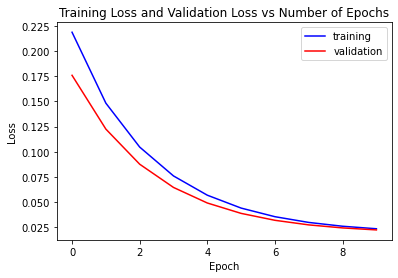

In [182]:
# Plot the training and validation loss versus the number of epochs.
tr_loss = []
val_loss = []

for i in range(10):
  tr_loss.append(history.history["loss"][i])
  val_loss.append(history.history["val_loss"][i])
  
plt.plot(range(10), tr_loss, "-b", label="training")
plt.plot(range(10), val_loss, "-r", label="validation")
plt.legend(loc="upper right")
plt.title("Training Loss and Validation Loss vs Number of Epochs for lat_dim=5")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

In [152]:
# MSE for test predictions
test_scores = model.evaluate(X_test, y_test, batch_size = 128, verbose=2)
print("Test MSE loss:", test_scores[0])

79/79 - 0s - loss: 0.0199 - mean_squared_error: 0.0199 - 139ms/epoch - 2ms/step
Test MSE loss: 0.019896352663636208


The model is trained again but with lat_dim=100.

In [181]:
# Compiling model
# Optimiser is SGD with learning rate (0.0001)
lat_dim = 100
no_epochs = 10
l_rate = 0.0001
batch_size = 128
val_split = 0.1

optimiser = tf.optimizers.SGD(learning_rate=l_rate)
model = sum_model(lat_dim)

model.compile(optimizer=optimiser, loss='mse', metrics=[tf.keras.metrics.MeanSquaredError()])

history = model.fit(X_train,                          # training samples
                    y_train,                          # training labels
                    epochs=no_epochs,                 # training steps (epochs)
                    batch_size=batch_size,           # how many data samples per training epoch
                    validation_split=val_split)

Epoch 1/10


690/704 [============================>.] - ETA: 0s - loss: 0.2193 - mean_squared_error: 0.2193

704/704 [==============================] - 3s 4ms/step - loss: 0.2186 - mean_squared_error: 0.2186 - val_loss: 0.1759 - val_mean_squared_error: 0.1759
Epoch 2/10
704/704 [==============================] - 2s 3ms/step - loss: 0.1483 - mean_squared_error: 0.1483 - val_loss: 0.1225 - val_mean_squared_error: 0.1225
Epoch 3/10
704/704 [==============================] - 5s 8ms/step - loss: 0.1047 - mean_squared_error: 0.1047 - val_loss: 0.0877 - val_mean_squared_error: 0.0877
Epoch 4/10
704/704 [==============================] - 5s 7ms/step - loss: 0.0761 - mean_squared_error: 0.0761 - val_loss: 0.0647 - val_mean_squared_error: 0.0647
Epoch 5/10
704/704 [==============================] - 2s 3ms/step - loss: 0.0570 - mean_squared_error: 0.0570 - val_loss: 0.0493 - val_mean_squared_error: 0.0493
Epoch 6/10
704/704 [==============================] - 2s 3ms/step - loss: 0.0442 - mean_squared_error: 0.0442 - val_loss: 0.0390 - val_mean_squared_error: 0.0390
Epoch 7/10
704/704 [===================

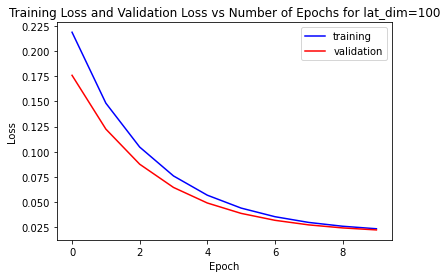

In [183]:
# Plot the training and validation loss versus the number of epochs.
tr_loss = []
val_loss = []

for i in range(10):
  tr_loss.append(history.history["loss"][i])
  val_loss.append(history.history["val_loss"][i])
  
plt.plot(range(10), tr_loss, "-b", label="training")
plt.plot(range(10), val_loss, "-r", label="validation")
plt.legend(loc="upper right")
plt.title("Training Loss and Validation Loss vs Number of Epochs for lat_dim=100")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

In [184]:
# MSE for test predictions
test_scores = model.evaluate(X_test, y_test, batch_size = 128, verbose=2)
print("Test MSE loss:", test_scores[0])

79/79 - 0s - loss: 0.0230 - mean_squared_error: 0.0230 - 242ms/epoch - 3ms/step
Test MSE loss: 0.023005684837698936


**Difference in results of lat_dim = 5 and lat_dim = 100:**

The shape of both graphs are largely similar. However, the MSE test loss is smaller for lat_dim = 5, at 0.0199, compared to 0.0230 for lat_dim = 100. 

This could be explained by considering that increasing the number of latent dimensions leads to a more complex model, and thus is likely more prone to overfitting. More investigation would need to be done to find the optimal number of latent dimensions that find the balance between complexity and overfitting.


**P1.3**


The model is now trained with varying learning rates (0.01, 0.1 and 0.5) and lat_dim = 100 over 10 epochs.

Epoch 1/10


699/704 [============================>.] - ETA: 0s - loss: 0.0239 - mean_squared_error: 0.0239

704/704 [==============================] - 5s 5ms/step - loss: 0.0238 - mean_squared_error: 0.0238 - val_loss: 0.0187 - val_mean_squared_error: 0.0187
Epoch 2/10
704/704 [==============================] - 2s 3ms/step - loss: 0.0188 - mean_squared_error: 0.0188 - val_loss: 0.0187 - val_mean_squared_error: 0.0187
Epoch 3/10
704/704 [==============================] - 2s 3ms/step - loss: 0.0188 - mean_squared_error: 0.0188 - val_loss: 0.0187 - val_mean_squared_error: 0.0187
Epoch 4/10
704/704 [==============================] - 2s 3ms/step - loss: 0.0188 - mean_squared_error: 0.0188 - val_loss: 0.0187 - val_mean_squared_error: 0.0187
Epoch 5/10
704/704 [==============================] - 2s 3ms/step - loss: 0.0187 - mean_squared_error: 0.0187 - val_loss: 0.0187 - val_mean_squared_error: 0.0187
Epoch 6/10
704/704 [==============================] - 3s 5ms/step - loss: 0.0187 - mean_squared_error: 0.0187 - val_loss: 0.0187 - val_mean_squared_error: 0.0187
Epoch 7/10
704/704 [===================

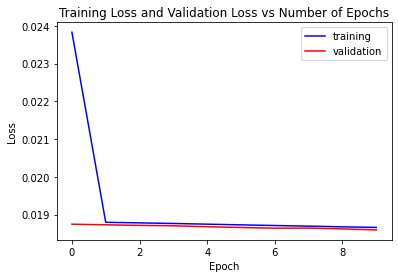

In [185]:
# Optimiser is SGD with learning rate (0.01)
lat_dim = 100
no_epochs = 10
l_rate = 0.01
batch_size = 128
val_split = 0.1

optimiser = tf.optimizers.SGD(learning_rate=l_rate)
model = sum_model(lat_dim)

model.compile(optimizer=optimiser, loss='mse', metrics=[tf.keras.metrics.MeanSquaredError()])

history = model.fit(X_train,                          # training samples
                    y_train,                          # training labels
                    epochs=no_epochs,                 # training steps (epochs)
                    batch_size=batch_size,           # how many data samples per training epoch
                    validation_split=val_split)

test_scores = model.evaluate(X_test, y_test, batch_size = 128, verbose=2)
print("Test MSE loss:", test_scores[0])

# Plot the training and validation loss versus the number of epochs.
tr_loss = []
val_loss = []

for i in range(10):
  tr_loss.append(history.history["loss"][i])
  val_loss.append(history.history["val_loss"][i])
  
plt.plot(range(10), tr_loss, "-b", label="training")
plt.plot(range(10), val_loss, "-r", label="validation")
plt.legend(loc="upper right")
plt.title("Training Loss and Validation Loss vs Number of Epochs")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

Epoch 1/10


690/704 [============================>.] - ETA: 0s - loss: 0.0197 - mean_squared_error: 0.0197

704/704 [==============================] - 3s 3ms/step - loss: 0.0197 - mean_squared_error: 0.0197 - val_loss: 0.0190 - val_mean_squared_error: 0.0190
Epoch 2/10
704/704 [==============================] - 2s 3ms/step - loss: 0.0190 - mean_squared_error: 0.0190 - val_loss: 0.0194 - val_mean_squared_error: 0.0194
Epoch 3/10
704/704 [==============================] - 4s 5ms/step - loss: 0.0189 - mean_squared_error: 0.0189 - val_loss: 0.0190 - val_mean_squared_error: 0.0190
Epoch 4/10
704/704 [==============================] - 2s 3ms/step - loss: 0.0189 - mean_squared_error: 0.0189 - val_loss: 0.0188 - val_mean_squared_error: 0.0188
Epoch 5/10
704/704 [==============================] - 2s 3ms/step - loss: 0.0188 - mean_squared_error: 0.0188 - val_loss: 0.0188 - val_mean_squared_error: 0.0188
Epoch 6/10
704/704 [==============================] - 2s 3ms/step - loss: 0.0187 - mean_squared_error: 0.0187 - val_loss: 0.0186 - val_mean_squared_error: 0.0186
Epoch 7/10
704/704 [===================

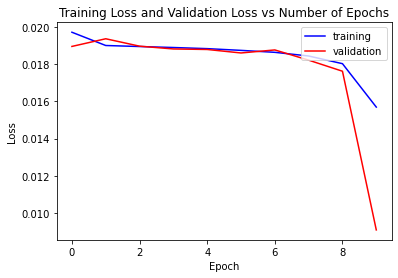

In [186]:
# Building model
# Optimiser is SGD with learning rate (0.1)
lat_dim = 100
no_epochs = 10
l_rate = 0.1
batch_size = 128
val_split = 0.1

optimiser = tf.optimizers.SGD(learning_rate=l_rate)
model = sum_model(lat_dim)

model.compile(optimizer=optimiser, loss='mse', metrics=[tf.keras.metrics.MeanSquaredError()])

history = model.fit(X_train,                          # training samples
                    y_train,                          # training labels
                    epochs=no_epochs,                 # training steps (epochs)
                    batch_size=batch_size,           # how many data samples per training epoch
                    validation_split=val_split)
test_scores = model.evaluate(X_test, y_test, batch_size = 128, verbose=2)
print("Test MSE loss:", test_scores[0])

# Plot the training and validation loss versus the number of epochs.
tr_loss = []
val_loss = []

for i in range(10):
  tr_loss.append(history.history["loss"][i])
  val_loss.append(history.history["val_loss"][i])
  
plt.plot(range(10), tr_loss, "-b", label="training")
plt.plot(range(10), val_loss, "-r", label="validation")
plt.legend(loc="upper right")
plt.title("Training Loss and Validation Loss vs Number of Epochs")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

Epoch 1/10


698/704 [============================>.] - ETA: 0s - loss: 0.0200 - mean_squared_error: 0.0200

704/704 [==============================] - 4s 5ms/step - loss: 0.0200 - mean_squared_error: 0.0200 - val_loss: 0.0187 - val_mean_squared_error: 0.0187
Epoch 2/10
704/704 [==============================] - 5s 7ms/step - loss: 0.0190 - mean_squared_error: 0.0190 - val_loss: 0.0191 - val_mean_squared_error: 0.0191
Epoch 3/10
704/704 [==============================] - 3s 4ms/step - loss: 0.0160 - mean_squared_error: 0.0160 - val_loss: 0.0095 - val_mean_squared_error: 0.0095
Epoch 4/10
704/704 [==============================] - 4s 6ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0072 - val_mean_squared_error: 0.0072
Epoch 5/10
704/704 [==============================] - 3s 4ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 6/10
704/704 [==============================] - 3s 4ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0061 - val_mean_squared_error: 0.0061
Epoch 7/10
704/704 [===================

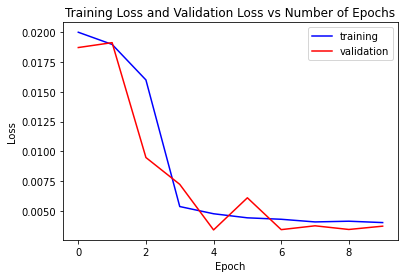

In [188]:
# Building model
# Optimiser is SGD with learning rate (0.5)
lat_dim = 100
no_epochs = 10
l_rate = 0.5
batch_size = 128
val_split = 0.1

optimiser = tf.optimizers.SGD(learning_rate=l_rate)
model = sum_model(lat_dim)

model.compile(optimizer=optimiser, loss='mse', metrics=[tf.keras.metrics.MeanSquaredError()])

history = model.fit(X_train,                          # training samples
                    y_train,                          # training labels
                    epochs=no_epochs,                 # training steps (epochs)
                    batch_size=batch_size,           # how many data samples per training epoch
                    validation_split=val_split)

test_scores = model.evaluate(X_test, y_test, batch_size = 128, verbose=2)
print("Test MSE loss:", test_scores[0])

# Plot the training and validation loss versus the number of epochs.
tr_loss = []
val_loss = []

for i in range(10):
  tr_loss.append(history.history["loss"][i])
  val_loss.append(history.history["val_loss"][i])
  
plt.plot(range(10), tr_loss, "-b", label="training")
plt.plot(range(10), val_loss, "-r", label="validation")
plt.legend(loc="upper right")
plt.title("Training Loss and Validation Loss vs Number of Epochs")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

**Investigating varying learning rates (0.0001, 0.01, 0.1, and 0.5):**


The learning has a big impact on the model as it controls the step size of the optimisation algorithm during the training phase.

A learning rate of 0.0001 is shown to have a relatively smooth convergence of training and validation loss towards 0, and the test MSE is quite low at 0.023.

The increase of learning rate to 0.01 has a big effect on the training and validation loss. These both rapidly shrink in only the second epoch.

The increase to 0.1 shows an immediate convergence of validation and training loss to around 0.019. In this case, these both remain quite steady here but shrink suddenly on the last epoch.

The training and validation loss graph for learning rate of 0.5 is particularly interesting as the values vary quite drastically for each epoch, althought it does seem to converge closely towards zero in the final few epochs.

The question of overfitting with increasingly large learning rate is raised, but interestingly the test MSE loss does decrease progressively as the learning rate increases, suggesting that in fact the learning rate of 0.5 might provide the best model. 

However, more investigation into other measures and factors, and a view over a larger number of epochs would be needed to conclude this, especially given that it is quite surprising for a model with learning rate of 0.5 to perform the best. 



**P1.4**

The model is now trained over 50 epochs.

In [167]:
# Building model
# Optimiser is SGD with learning rate (0.0001)
l_rate = 0.0001
batch_size = 128
val_split = 0.1
lat_dim = 100
no_epochs = 50

model = sum_model(lat_dim)

optimiser = tf.optimizers.SGD(learning_rate=l_rate)

model.compile(optimizer=optimiser, loss='mse', metrics=[tf.keras.metrics.MeanSquaredError()])


history = model.fit(X_train,                          # training samples
                    y_train,                          # training labels
                    epochs=no_epochs,                 # training steps (epochs)
                    batch_size=batch_size,           # how many data samples per training epoch
                    validation_split=val_split)

test_scores = model.evaluate(X_test, y_test, batch_size = 128, verbose=2)
print("Test MSE loss:", test_scores[0])

Epoch 1/50


698/704 [============================>.] - ETA: 0s - loss: 0.2209 - mean_squared_error: 0.2209

704/704 [==============================] - 5s 5ms/step - loss: 0.2206 - mean_squared_error: 0.2206 - val_loss: 0.1780 - val_mean_squared_error: 0.1780
Epoch 2/50
704/704 [==============================] - 2s 3ms/step - loss: 0.1502 - mean_squared_error: 0.1502 - val_loss: 0.1248 - val_mean_squared_error: 0.1248
Epoch 3/50
704/704 [==============================] - 2s 3ms/step - loss: 0.1072 - mean_squared_error: 0.1072 - val_loss: 0.0903 - val_mean_squared_error: 0.0903
Epoch 4/50
704/704 [==============================] - 2s 3ms/step - loss: 0.0785 - mean_squared_error: 0.0785 - val_loss: 0.0668 - val_mean_squared_error: 0.0668
Epoch 5/50
704/704 [==============================] - 3s 4ms/step - loss: 0.0589 - mean_squared_error: 0.0589 - val_loss: 0.0510 - val_mean_squared_error: 0.0510
Epoch 6/50
704/704 [==============================] - 3s 5ms/step - loss: 0.0458 - mean_squared_error: 0.0458 - val_loss: 0.0403 - val_mean_squared_error: 0.0403
Epoch 7/50
704/704 [===================

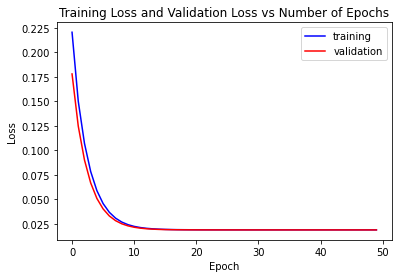

In [168]:
# Plot the training and validation loss versus the number of epochs.
tr_loss = []
val_loss = []

for i in range(50):
  tr_loss.append(history.history["loss"][i])
  val_loss.append(history.history["val_loss"][i])
  
plt.plot(range(50), tr_loss, "-b", label="training")
plt.plot(range(50), val_loss, "-r", label="validation")
plt.legend(loc="upper right")
plt.title("Training Loss and Validation Loss vs Number of Epochs")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

The original model implementation is adjusted to use sigmoid activation functions instead of ReLU activation functions, and the model is fitted over 50 epochs.

In [189]:
def phi1(lat_dim):
  input_layer = tf.keras.Input(shape=(10,))
  layer_one = tf.keras.layers.Dense(100, activation="sigmoid")(input_layer)
  output = tf.keras.layers.Dense(lat_dim, activation="softmax")(layer_one)
  return tf.keras.Model(inputs=input_layer, outputs=output)
  
def rho1(lat_dim):
  input = tf.keras.Input(shape=(lat_dim,))
  layer_one = tf.keras.layers.Dense(100, activation="sigmoid")(input)
  output = tf.keras.layers.Dense(1, activation="linear")(layer_one)
  return tf.keras.Model(inputs=input, outputs=output)

def sum_model1(lat_dim):
    input_layer = tf.keras.Input(shape=(None, 10))
    reshaped_input = tf.keras.layers.Reshape((1, 10))(input_layer)
    phi_layer = tf.keras.layers.TimeDistributed(phi1(lat_dim))(reshaped_input)
    phi_sum_layer = tf.keras.layers.Lambda(lambda x: tf.reduce_sum(x, axis=1))(phi_layer)
    rho_layer = rho1(lat_dim)(phi_sum_layer)
    return tf.keras.Model(inputs=input_layer, outputs=rho_layer)


# Building model
# Optimiser is SGD with learning rate (0.0001)
l_rate = 0.0001
batch_size = 128
val_split = 0.1
lat_dim = 100
no_epochs = 50

optimiser = tf.optimizers.SGD(learning_rate=l_rate)
model = sum_model1(lat_dim)
model.compile(optimizer=optimiser, loss='mse', metrics=[tf.keras.metrics.MeanSquaredError()])


history = model.fit(X_train,                          # training samples
                    y_train,                          # training labels
                    epochs=no_epochs,                 # training steps (epochs)
                    batch_size=batch_size,           # how many data samples per training epoch
                    validation_split=val_split)

test_scores = model.evaluate(X_test, y_test, batch_size = 128, verbose=2)
print("Test MSE loss:", test_scores[0])

Epoch 1/50


701/704 [============================>.] - ETA: 0s - loss: 0.0769 - mean_squared_error: 0.0769

704/704 [==============================] - 4s 5ms/step - loss: 0.0767 - mean_squared_error: 0.0767 - val_loss: 0.0191 - val_mean_squared_error: 0.0191
Epoch 2/50
704/704 [==============================] - 3s 5ms/step - loss: 0.0190 - mean_squared_error: 0.0190 - val_loss: 0.0189 - val_mean_squared_error: 0.0189
Epoch 3/50
704/704 [==============================] - 2s 3ms/step - loss: 0.0190 - mean_squared_error: 0.0190 - val_loss: 0.0189 - val_mean_squared_error: 0.0189
Epoch 4/50
704/704 [==============================] - 2s 3ms/step - loss: 0.0190 - mean_squared_error: 0.0190 - val_loss: 0.0189 - val_mean_squared_error: 0.0189
Epoch 5/50
704/704 [==============================] - 3s 4ms/step - loss: 0.0190 - mean_squared_error: 0.0190 - val_loss: 0.0189 - val_mean_squared_error: 0.0189
Epoch 6/50
704/704 [==============================] - 3s 5ms/step - loss: 0.0190 - mean_squared_error: 0.0190 - val_loss: 0.0189 - val_mean_squared_error: 0.0189
Epoch 7/50
704/704 [===================

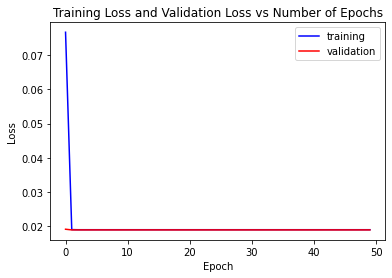

In [192]:
# Plot the training and validation loss versus the number of epochs.
tr_loss = []
val_loss = []

for i in range(50):
  tr_loss.append(history.history["loss"][i])
  val_loss.append(history.history["val_loss"][i])
  
plt.plot(range(50), tr_loss, "-b", label="training")
plt.plot(range(50), val_loss, "-r", label="validation")
plt.legend(loc="upper right")
plt.title("Training Loss and Validation Loss vs Number of Epochs")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

**Impact of changing ReLU activation to Sigmoid activation:**

The training loss of the model using a Sigmoid activation function starts off very high in the first epoch, but then almost immediately converges to 0.019 and does not vary much over the rest of the epochs. The loss for the ReLU model converges much more gradually than the sigmoid model. Interestingly, the validation loss for the sigmoid model also stays almost constant throughout all epochs.

The test MSE values are quite similar for both, with the ReLU model having a slightly lower MSE than for the sigmoid model (0.0191 vs. 0.0192).

These results are quite surprising as use of the sigmoid function usually leads to slower convergence than using ReLU. This finding could suggest that a sigmoid activation function leads to a better model than a ReLU activation function in this case, but further investigation is needed. For example, this finding might not hold (and in fact use of sigmoid activation might be invalid) if a larger learning rate is used.










**P1.5**


The neural network architecture is now evaluated for different values of lat_dim - [1,2,5,10,20,30,50,80,90,100]. For each setting of lat_dim, 5 independent training runs are done, each for 5 epochs. For each training run, the best model is selected with respect to the MSE validation metric. For each lat_dim, the average is taken over the test MSE values of the best models for each training run.r

In [193]:
# The overall model is redefined and the function output is redefined to be the compiled model (wrt lat_dim)
def phi(lat_dim):
  input_layer = tf.keras.Input(shape=(10,))
  layer_one = tf.keras.layers.Dense(100, activation="relu")(input_layer)
  output = tf.keras.layers.Dense(lat_dim, activation="softmax")(layer_one)
  return tf.keras.Model(inputs=input_layer, outputs=output)
  
def rho(lat_dim):
  input = tf.keras.Input(shape=(lat_dim,))
  layer_one = tf.keras.layers.Dense(100, activation="relu")(input)
  output = tf.keras.layers.Dense(1, activation="linear")(layer_one)
  return tf.keras.Model(inputs=input, outputs=output)

def create_model(lat_dim):
    input_layer = tf.keras.Input(shape=(None, 10))
    reshaped_input = tf.keras.layers.Reshape((1, 10))(input_layer)
    phi_layer = tf.keras.layers.TimeDistributed(phi(lat_dim))(reshaped_input)
    phi_sum_layer = tf.keras.layers.Lambda(lambda x: tf.reduce_sum(x, axis=1))(phi_layer)
    rho_layer = rho(lat_dim)(phi_sum_layer)
    model = tf.keras.Model(inputs=input_layer, outputs=rho_layer) 
    optimiser = tf.optimizers.SGD(learning_rate=l_rate)

    model.compile(optimizer=optimiser, loss='mse', metrics=[tf.keras.metrics.MeanSquaredError()])
    return model

# Variables are defined
lat_dims = [1,2,5,10,20,30,50,80,90,100]
l_rate = 0.0001
batch_size = 128
val_split = 0.1
tr_runs = 5
no_epochs = 5

# Array created to hold mean MSE values
mse_overall = []

for lat_dim in lat_dims: 
  # Array created for each value of lat_dim to hold test MSE of best model chosen for that value of lat_dim
  mse_current = []
  for i in range(tr_runs):
    test_model = create_model(lat_dim)
    history = test_model.fit(X_train,                          # training samples
                    y_train,                                   # training labels
                    epochs=no_epochs,                          # training steps (epochs)
                    batch_size=batch_size,                     # how many data samples per training epoch
                    validation_split=val_split,           
                    callbacks=[tf.keras.callbacks.ModelCheckpoint(filepath="best_model.h5",   
                                                                    save_best_only=True)])
    # The ModelCheckpoint callback method is used to save the best model, 
    # according to minimum validation loss, within these 5 epochs
    # 'save_best_only' ensure only this best model is saved

    # Loads the model saved during model fitting
    best_model = tf.keras.models.load_model("best_model.h5") 

    # Evaluated models on test data and adds MSE to the array for current value of lat_dim
    test_scores = best_model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
    mse_current.append(test_scores[0])


  # Computes the average test MSE over every run and adds it to overall MSE array
  mse_mean = np.mean(mse_current)
  mse_overall.append(mse_mean)


Epoch 1/5


685/704 [============================>.] - ETA: 0s - loss: 0.2070 - mean_squared_error: 0.2070

704/704 [==============================] - 3s 3ms/step - loss: 0.2047 - mean_squared_error: 0.2047 - val_loss: 0.1232 - val_mean_squared_error: 0.1232
Epoch 2/5
704/704 [==============================] - 2s 3ms/step - loss: 0.0840 - mean_squared_error: 0.0840 - val_loss: 0.0549 - val_mean_squared_error: 0.0549
Epoch 3/5
704/704 [==============================] - 2s 3ms/step - loss: 0.0414 - mean_squared_error: 0.0414 - val_loss: 0.0312 - val_mean_squared_error: 0.0312
Epoch 4/5
704/704 [==============================] - 3s 4ms/step - loss: 0.0266 - mean_squared_error: 0.0266 - val_loss: 0.0230 - val_mean_squared_error: 0.0230
Epoch 5/5
704/704 [==============================] - 3s 4ms/step - loss: 0.0216 - mean_squared_error: 0.0216 - val_loss: 0.0203 - val_mean_squared_error: 0.0203


Epoch 1/5


692/704 [============================>.] - ETA: 0s - loss: 0.3751 - mean_squared_error: 0.3751

704/704 [==============================] - 6s 8ms/step - loss: 0.3724 - mean_squared_error: 0.3724 - val_loss: 0.2024 - val_mean_squared_error: 0.2024
Epoch 2/5
704/704 [==============================] - 3s 5ms/step - loss: 0.1276 - mean_squared_error: 0.1276 - val_loss: 0.0751 - val_mean_squared_error: 0.0751
Epoch 3/5
704/704 [==============================] - 2s 3ms/step - loss: 0.0526 - mean_squared_error: 0.0526 - val_loss: 0.0364 - val_mean_squared_error: 0.0364
Epoch 4/5
704/704 [==============================] - 2s 3ms/step - loss: 0.0295 - mean_squared_error: 0.0295 - val_loss: 0.0243 - val_mean_squared_error: 0.0243
Epoch 5/5
704/704 [==============================] - 2s 3ms/step - loss: 0.0222 - mean_squared_error: 0.0222 - val_loss: 0.0205 - val_mean_squared_error: 0.0205


Epoch 1/5


703/704 [============================>.] - ETA: 0s - loss: 0.3510 - mean_squared_error: 0.3510

704/704 [==============================] - 5s 5ms/step - loss: 0.3510 - mean_squared_error: 0.3510 - val_loss: 0.2240 - val_mean_squared_error: 0.2240
Epoch 2/5
704/704 [==============================] - 2s 3ms/step - loss: 0.1563 - mean_squared_error: 0.1563 - val_loss: 0.1038 - val_mean_squared_error: 0.1038
Epoch 3/5
704/704 [==============================] - 3s 4ms/step - loss: 0.0758 - mean_squared_error: 0.0758 - val_loss: 0.0538 - val_mean_squared_error: 0.0538
Epoch 4/5
704/704 [==============================] - 4s 6ms/step - loss: 0.0424 - mean_squared_error: 0.0424 - val_loss: 0.0331 - val_mean_squared_error: 0.0331
Epoch 5/5
704/704 [==============================] - 4s 6ms/step - loss: 0.0286 - mean_squared_error: 0.0286 - val_loss: 0.0247 - val_mean_squared_error: 0.0247


Epoch 1/5


696/704 [============================>.] - ETA: 0s - loss: 0.0893 - mean_squared_error: 0.0893

704/704 [==============================] - 3s 3ms/step - loss: 0.0890 - mean_squared_error: 0.0890 - val_loss: 0.0534 - val_mean_squared_error: 0.0534
Epoch 2/5
704/704 [==============================] - 3s 4ms/step - loss: 0.0389 - mean_squared_error: 0.0389 - val_loss: 0.0286 - val_mean_squared_error: 0.0286
Epoch 3/5
704/704 [==============================] - 4s 5ms/step - loss: 0.0246 - mean_squared_error: 0.0246 - val_loss: 0.0216 - val_mean_squared_error: 0.0216
Epoch 4/5
704/704 [==============================] - 3s 5ms/step - loss: 0.0206 - mean_squared_error: 0.0206 - val_loss: 0.0197 - val_mean_squared_error: 0.0197
Epoch 5/5
704/704 [==============================] - 3s 4ms/step - loss: 0.0194 - mean_squared_error: 0.0194 - val_loss: 0.0191 - val_mean_squared_error: 0.0191


Epoch 1/5


699/704 [============================>.] - ETA: 0s - loss: 0.2951 - mean_squared_error: 0.2951

704/704 [==============================] - 3s 4ms/step - loss: 0.2944 - mean_squared_error: 0.2944 - val_loss: 0.1639 - val_mean_squared_error: 0.1639
Epoch 2/5
704/704 [==============================] - 4s 6ms/step - loss: 0.1060 - mean_squared_error: 0.1060 - val_loss: 0.0650 - val_mean_squared_error: 0.0650
Epoch 3/5
704/704 [==============================] - 4s 6ms/step - loss: 0.0468 - mean_squared_error: 0.0468 - val_loss: 0.0334 - val_mean_squared_error: 0.0334
Epoch 4/5
704/704 [==============================] - 3s 4ms/step - loss: 0.0278 - mean_squared_error: 0.0278 - val_loss: 0.0235 - val_mean_squared_error: 0.0235
Epoch 5/5
704/704 [==============================] - 2s 3ms/step - loss: 0.0218 - mean_squared_error: 0.0218 - val_loss: 0.0203 - val_mean_squared_error: 0.0203


Epoch 1/5


700/704 [============================>.] - ETA: 0s - loss: 0.2535 - mean_squared_error: 0.2535

704/704 [==============================] - 6s 8ms/step - loss: 0.2531 - mean_squared_error: 0.2531 - val_loss: 0.1801 - val_mean_squared_error: 0.1801
Epoch 2/5
704/704 [==============================] - 2s 3ms/step - loss: 0.1363 - mean_squared_error: 0.1363 - val_loss: 0.0997 - val_mean_squared_error: 0.0997
Epoch 3/5
704/704 [==============================] - 4s 5ms/step - loss: 0.0776 - mean_squared_error: 0.0776 - val_loss: 0.0587 - val_mean_squared_error: 0.0587
Epoch 4/5
704/704 [==============================] - 3s 5ms/step - loss: 0.0478 - mean_squared_error: 0.0478 - val_loss: 0.0382 - val_mean_squared_error: 0.0382
Epoch 5/5
704/704 [==============================] - 3s 4ms/step - loss: 0.0330 - mean_squared_error: 0.0330 - val_loss: 0.0281 - val_mean_squared_error: 0.0281


Epoch 1/5


701/704 [============================>.] - ETA: 0s - loss: 0.2788 - mean_squared_error: 0.2788

704/704 [==============================] - 4s 4ms/step - loss: 0.2785 - mean_squared_error: 0.2785 - val_loss: 0.1899 - val_mean_squared_error: 0.1899
Epoch 2/5
704/704 [==============================] - 5s 8ms/step - loss: 0.1395 - mean_squared_error: 0.1395 - val_loss: 0.0985 - val_mean_squared_error: 0.0985
Epoch 3/5
704/704 [==============================] - 6s 9ms/step - loss: 0.0752 - mean_squared_error: 0.0752 - val_loss: 0.0559 - val_mean_squared_error: 0.0559
Epoch 4/5
704/704 [==============================] - 3s 4ms/step - loss: 0.0451 - mean_squared_error: 0.0451 - val_loss: 0.0359 - val_mean_squared_error: 0.0359
Epoch 5/5
704/704 [==============================] - 3s 4ms/step - loss: 0.0311 - mean_squared_error: 0.0311 - val_loss: 0.0267 - val_mean_squared_error: 0.0267


Epoch 1/5


702/704 [============================>.] - ETA: 0s - loss: 0.2261 - mean_squared_error: 0.2261

704/704 [==============================] - 7s 8ms/step - loss: 0.2260 - mean_squared_error: 0.2260 - val_loss: 0.1467 - val_mean_squared_error: 0.1467
Epoch 2/5
704/704 [==============================] - 2s 4ms/step - loss: 0.1040 - mean_squared_error: 0.1040 - val_loss: 0.0704 - val_mean_squared_error: 0.0704
Epoch 3/5
704/704 [==============================] - 3s 4ms/step - loss: 0.0529 - mean_squared_error: 0.0529 - val_loss: 0.0388 - val_mean_squared_error: 0.0388
Epoch 4/5
704/704 [==============================] - 3s 4ms/step - loss: 0.0317 - mean_squared_error: 0.0317 - val_loss: 0.0258 - val_mean_squared_error: 0.0258
Epoch 5/5
704/704 [==============================] - 4s 6ms/step - loss: 0.0231 - mean_squared_error: 0.0231 - val_loss: 0.0207 - val_mean_squared_error: 0.0207


Epoch 1/5


701/704 [============================>.] - ETA: 0s - loss: 0.2666 - mean_squared_error: 0.2666

704/704 [==============================] - 4s 5ms/step - loss: 0.2663 - mean_squared_error: 0.2663 - val_loss: 0.1705 - val_mean_squared_error: 0.1705
Epoch 2/5
704/704 [==============================] - 3s 5ms/step - loss: 0.1222 - mean_squared_error: 0.1222 - val_loss: 0.0845 - val_mean_squared_error: 0.0845
Epoch 3/5
704/704 [==============================] - 5s 6ms/step - loss: 0.0643 - mean_squared_error: 0.0643 - val_loss: 0.0477 - val_mean_squared_error: 0.0477
Epoch 4/5
704/704 [==============================] - 3s 4ms/step - loss: 0.0390 - mean_squared_error: 0.0390 - val_loss: 0.0316 - val_mean_squared_error: 0.0316
Epoch 5/5
704/704 [==============================] - 3s 4ms/step - loss: 0.0278 - mean_squared_error: 0.0278 - val_loss: 0.0244 - val_mean_squared_error: 0.0244


Epoch 1/5


695/704 [============================>.] - ETA: 0s - loss: 0.2081 - mean_squared_error: 0.2081

704/704 [==============================] - 5s 5ms/step - loss: 0.2074 - mean_squared_error: 0.2074 - val_loss: 0.1434 - val_mean_squared_error: 0.1434
Epoch 2/5
704/704 [==============================] - 4s 5ms/step - loss: 0.1065 - mean_squared_error: 0.1065 - val_loss: 0.0765 - val_mean_squared_error: 0.0765
Epoch 3/5
704/704 [==============================] - 3s 4ms/step - loss: 0.0596 - mean_squared_error: 0.0596 - val_loss: 0.0454 - val_mean_squared_error: 0.0454
Epoch 4/5
704/704 [==============================] - 3s 5ms/step - loss: 0.0377 - mean_squared_error: 0.0377 - val_loss: 0.0310 - val_mean_squared_error: 0.0310
Epoch 5/5
704/704 [==============================] - 4s 5ms/step - loss: 0.0276 - mean_squared_error: 0.0276 - val_loss: 0.0244 - val_mean_squared_error: 0.0244


Epoch 1/5


696/704 [============================>.] - ETA: 0s - loss: 0.2665 - mean_squared_error: 0.2665

704/704 [==============================] - 3s 4ms/step - loss: 0.2657 - mean_squared_error: 0.2657 - val_loss: 0.1873 - val_mean_squared_error: 0.1873
Epoch 2/5
704/704 [==============================] - 3s 4ms/step - loss: 0.1411 - mean_squared_error: 0.1411 - val_loss: 0.1028 - val_mean_squared_error: 0.1028
Epoch 3/5
704/704 [==============================] - 3s 4ms/step - loss: 0.0804 - mean_squared_error: 0.0804 - val_loss: 0.0613 - val_mean_squared_error: 0.0613
Epoch 4/5
704/704 [==============================] - 3s 5ms/step - loss: 0.0502 - mean_squared_error: 0.0502 - val_loss: 0.0404 - val_mean_squared_error: 0.0404
Epoch 5/5
704/704 [==============================] - 4s 6ms/step - loss: 0.0349 - mean_squared_error: 0.0349 - val_loss: 0.0298 - val_mean_squared_error: 0.0298


Epoch 1/5


702/704 [============================>.] - ETA: 0s - loss: 0.2057 - mean_squared_error: 0.2057

704/704 [==============================] - 6s 7ms/step - loss: 0.2056 - mean_squared_error: 0.2056 - val_loss: 0.1450 - val_mean_squared_error: 0.1450
Epoch 2/5
704/704 [==============================] - 5s 7ms/step - loss: 0.1097 - mean_squared_error: 0.1097 - val_loss: 0.0805 - val_mean_squared_error: 0.0805
Epoch 3/5
704/704 [==============================] - 4s 5ms/step - loss: 0.0636 - mean_squared_error: 0.0636 - val_loss: 0.0492 - val_mean_squared_error: 0.0492
Epoch 4/5
704/704 [==============================] - 5s 7ms/step - loss: 0.0412 - mean_squared_error: 0.0412 - val_loss: 0.0340 - val_mean_squared_error: 0.0340
Epoch 5/5
704/704 [==============================] - 5s 8ms/step - loss: 0.0302 - mean_squared_error: 0.0302 - val_loss: 0.0266 - val_mean_squared_error: 0.0266


Epoch 1/5


699/704 [============================>.] - ETA: 0s - loss: 0.1507 - mean_squared_error: 0.1507

704/704 [==============================] - 3s 3ms/step - loss: 0.1505 - mean_squared_error: 0.1505 - val_loss: 0.1088 - val_mean_squared_error: 0.1088
Epoch 2/5
704/704 [==============================] - 2s 3ms/step - loss: 0.0843 - mean_squared_error: 0.0843 - val_loss: 0.0638 - val_mean_squared_error: 0.0638
Epoch 3/5
704/704 [==============================] - 3s 4ms/step - loss: 0.0520 - mean_squared_error: 0.0520 - val_loss: 0.0417 - val_mean_squared_error: 0.0417
Epoch 4/5
704/704 [==============================] - 2s 3ms/step - loss: 0.0358 - mean_squared_error: 0.0358 - val_loss: 0.0304 - val_mean_squared_error: 0.0304
Epoch 5/5
704/704 [==============================] - 2s 3ms/step - loss: 0.0274 - mean_squared_error: 0.0274 - val_loss: 0.0245 - val_mean_squared_error: 0.0245


Epoch 1/5


699/704 [============================>.] - ETA: 0s - loss: 0.2031 - mean_squared_error: 0.2031

704/704 [==============================] - 3s 3ms/step - loss: 0.2028 - mean_squared_error: 0.2028 - val_loss: 0.1478 - val_mean_squared_error: 0.1478
Epoch 2/5
704/704 [==============================] - 2s 3ms/step - loss: 0.1153 - mean_squared_error: 0.1153 - val_loss: 0.0878 - val_mean_squared_error: 0.0878
Epoch 3/5
704/704 [==============================] - 2s 3ms/step - loss: 0.0710 - mean_squared_error: 0.0710 - val_loss: 0.0563 - val_mean_squared_error: 0.0563
Epoch 4/5
704/704 [==============================] - 3s 4ms/step - loss: 0.0475 - mean_squared_error: 0.0475 - val_loss: 0.0396 - val_mean_squared_error: 0.0396
Epoch 5/5
704/704 [==============================] - 2s 3ms/step - loss: 0.0349 - mean_squared_error: 0.0349 - val_loss: 0.0305 - val_mean_squared_error: 0.0305


Epoch 1/5


704/704 [==============================] - ETA: 0s - loss: 0.3169 - mean_squared_error: 0.3169

704/704 [==============================] - 3s 3ms/step - loss: 0.3169 - mean_squared_error: 0.3169 - val_loss: 0.2208 - val_mean_squared_error: 0.2208
Epoch 2/5
704/704 [==============================] - 2s 3ms/step - loss: 0.1645 - mean_squared_error: 0.1645 - val_loss: 0.1187 - val_mean_squared_error: 0.1187
Epoch 3/5
704/704 [==============================] - 2s 3ms/step - loss: 0.0920 - mean_squared_error: 0.0920 - val_loss: 0.0695 - val_mean_squared_error: 0.0695
Epoch 4/5
704/704 [==============================] - 5s 7ms/step - loss: 0.0564 - mean_squared_error: 0.0564 - val_loss: 0.0449 - val_mean_squared_error: 0.0449
Epoch 5/5
704/704 [==============================] - 2s 3ms/step - loss: 0.0383 - mean_squared_error: 0.0383 - val_loss: 0.0323 - val_mean_squared_error: 0.0323


Epoch 1/5


698/704 [============================>.] - ETA: 0s - loss: 0.2478 - mean_squared_error: 0.2478

704/704 [==============================] - 4s 4ms/step - loss: 0.2473 - mean_squared_error: 0.2473 - val_loss: 0.1868 - val_mean_squared_error: 0.1868
Epoch 2/5
704/704 [==============================] - 3s 4ms/step - loss: 0.1482 - mean_squared_error: 0.1482 - val_loss: 0.1144 - val_mean_squared_error: 0.1144
Epoch 3/5
704/704 [==============================] - 2s 3ms/step - loss: 0.0930 - mean_squared_error: 0.0930 - val_loss: 0.0740 - val_mean_squared_error: 0.0740
Epoch 4/5
704/704 [==============================] - 2s 3ms/step - loss: 0.0620 - mean_squared_error: 0.0620 - val_loss: 0.0509 - val_mean_squared_error: 0.0509
Epoch 5/5
704/704 [==============================] - 2s 3ms/step - loss: 0.0439 - mean_squared_error: 0.0439 - val_loss: 0.0373 - val_mean_squared_error: 0.0373


Epoch 1/5


701/704 [============================>.] - ETA: 0s - loss: 0.1617 - mean_squared_error: 0.1617

704/704 [==============================] - 3s 3ms/step - loss: 0.1616 - mean_squared_error: 0.1616 - val_loss: 0.1222 - val_mean_squared_error: 0.1222
Epoch 2/5
704/704 [==============================] - 2s 3ms/step - loss: 0.0973 - mean_squared_error: 0.0973 - val_loss: 0.0755 - val_mean_squared_error: 0.0755
Epoch 3/5
704/704 [==============================] - 7s 9ms/step - loss: 0.0621 - mean_squared_error: 0.0621 - val_loss: 0.0500 - val_mean_squared_error: 0.0500
Epoch 4/5
704/704 [==============================] - 4s 6ms/step - loss: 0.0427 - mean_squared_error: 0.0427 - val_loss: 0.0359 - val_mean_squared_error: 0.0359
Epoch 5/5
704/704 [==============================] - 5s 7ms/step - loss: 0.0320 - mean_squared_error: 0.0320 - val_loss: 0.0281 - val_mean_squared_error: 0.0281


Epoch 1/5


702/704 [============================>.] - ETA: 0s - loss: 0.2042 - mean_squared_error: 0.2042

704/704 [==============================] - 6s 5ms/step - loss: 0.2041 - mean_squared_error: 0.2041 - val_loss: 0.1573 - val_mean_squared_error: 0.1573
Epoch 2/5
704/704 [==============================] - 4s 6ms/step - loss: 0.1267 - mean_squared_error: 0.1267 - val_loss: 0.0995 - val_mean_squared_error: 0.0995
Epoch 3/5
704/704 [==============================] - 5s 7ms/step - loss: 0.0818 - mean_squared_error: 0.0818 - val_loss: 0.0657 - val_mean_squared_error: 0.0657
Epoch 4/5
704/704 [==============================] - 5s 7ms/step - loss: 0.0555 - mean_squared_error: 0.0555 - val_loss: 0.0460 - val_mean_squared_error: 0.0460
Epoch 5/5
704/704 [==============================] - 4s 5ms/step - loss: 0.0402 - mean_squared_error: 0.0402 - val_loss: 0.0345 - val_mean_squared_error: 0.0345


Epoch 1/5


700/704 [============================>.] - ETA: 0s - loss: 0.1786 - mean_squared_error: 0.1786

704/704 [==============================] - 5s 5ms/step - loss: 0.1784 - mean_squared_error: 0.1784 - val_loss: 0.1325 - val_mean_squared_error: 0.1325
Epoch 2/5
704/704 [==============================] - 4s 6ms/step - loss: 0.1041 - mean_squared_error: 0.1041 - val_loss: 0.0796 - val_mean_squared_error: 0.0796
Epoch 3/5
704/704 [==============================] - 4s 6ms/step - loss: 0.0647 - mean_squared_error: 0.0647 - val_loss: 0.0514 - val_mean_squared_error: 0.0514
Epoch 4/5
704/704 [==============================] - 3s 4ms/step - loss: 0.0435 - mean_squared_error: 0.0435 - val_loss: 0.0362 - val_mean_squared_error: 0.0362
Epoch 5/5
704/704 [==============================] - 2s 3ms/step - loss: 0.0320 - mean_squared_error: 0.0320 - val_loss: 0.0280 - val_mean_squared_error: 0.0280


Epoch 1/5


686/704 [============================>.] - ETA: 0s - loss: 0.1638 - mean_squared_error: 0.1638

704/704 [==============================] - 3s 3ms/step - loss: 0.1627 - mean_squared_error: 0.1627 - val_loss: 0.1151 - val_mean_squared_error: 0.1151
Epoch 2/5
704/704 [==============================] - 4s 6ms/step - loss: 0.0880 - mean_squared_error: 0.0880 - val_loss: 0.0655 - val_mean_squared_error: 0.0655
Epoch 3/5
704/704 [==============================] - 3s 4ms/step - loss: 0.0526 - mean_squared_error: 0.0526 - val_loss: 0.0415 - val_mean_squared_error: 0.0415
Epoch 4/5
704/704 [==============================] - 2s 3ms/step - loss: 0.0353 - mean_squared_error: 0.0353 - val_loss: 0.0297 - val_mean_squared_error: 0.0297
Epoch 5/5
704/704 [==============================] - 2s 3ms/step - loss: 0.0268 - mean_squared_error: 0.0268 - val_loss: 0.0239 - val_mean_squared_error: 0.0239


Epoch 1/5


692/704 [============================>.] - ETA: 0s - loss: 0.2099 - mean_squared_error: 0.2099

704/704 [==============================] - 3s 3ms/step - loss: 0.2092 - mean_squared_error: 0.2092 - val_loss: 0.1609 - val_mean_squared_error: 0.1609
Epoch 2/5
704/704 [==============================] - 2s 3ms/step - loss: 0.1289 - mean_squared_error: 0.1289 - val_loss: 0.1007 - val_mean_squared_error: 0.1007
Epoch 3/5
704/704 [==============================] - 2s 3ms/step - loss: 0.0824 - mean_squared_error: 0.0824 - val_loss: 0.0660 - val_mean_squared_error: 0.0660
Epoch 4/5
704/704 [==============================] - 2s 3ms/step - loss: 0.0556 - mean_squared_error: 0.0556 - val_loss: 0.0460 - val_mean_squared_error: 0.0460
Epoch 5/5
704/704 [==============================] - 3s 4ms/step - loss: 0.0401 - mean_squared_error: 0.0401 - val_loss: 0.0344 - val_mean_squared_error: 0.0344


Epoch 1/5


703/704 [============================>.] - ETA: 0s - loss: 0.2035 - mean_squared_error: 0.2035

704/704 [==============================] - 4s 5ms/step - loss: 0.2035 - mean_squared_error: 0.2035 - val_loss: 0.1575 - val_mean_squared_error: 0.1575
Epoch 2/5
704/704 [==============================] - 3s 4ms/step - loss: 0.1281 - mean_squared_error: 0.1281 - val_loss: 0.1019 - val_mean_squared_error: 0.1019
Epoch 3/5
704/704 [==============================] - 2s 3ms/step - loss: 0.0848 - mean_squared_error: 0.0848 - val_loss: 0.0690 - val_mean_squared_error: 0.0690
Epoch 4/5
704/704 [==============================] - 2s 3ms/step - loss: 0.0588 - mean_squared_error: 0.0588 - val_loss: 0.0492 - val_mean_squared_error: 0.0492
Epoch 5/5
704/704 [==============================] - 3s 4ms/step - loss: 0.0432 - mean_squared_error: 0.0432 - val_loss: 0.0373 - val_mean_squared_error: 0.0373


Epoch 1/5


695/704 [============================>.] - ETA: 0s - loss: 0.1970 - mean_squared_error: 0.1970

704/704 [==============================] - 7s 7ms/step - loss: 0.1965 - mean_squared_error: 0.1965 - val_loss: 0.1462 - val_mean_squared_error: 0.1462
Epoch 2/5
704/704 [==============================] - 3s 4ms/step - loss: 0.1153 - mean_squared_error: 0.1153 - val_loss: 0.0885 - val_mean_squared_error: 0.0885
Epoch 3/5
704/704 [==============================] - 5s 7ms/step - loss: 0.0722 - mean_squared_error: 0.0722 - val_loss: 0.0577 - val_mean_squared_error: 0.0577
Epoch 4/5
704/704 [==============================] - 6s 9ms/step - loss: 0.0489 - mean_squared_error: 0.0489 - val_loss: 0.0407 - val_mean_squared_error: 0.0407
Epoch 5/5
704/704 [==============================] - 3s 5ms/step - loss: 0.0359 - mean_squared_error: 0.0359 - val_loss: 0.0312 - val_mean_squared_error: 0.0312


Epoch 1/5


689/704 [============================>.] - ETA: 0s - loss: 0.2222 - mean_squared_error: 0.2222

704/704 [==============================] - 6s 7ms/step - loss: 0.2212 - mean_squared_error: 0.2212 - val_loss: 0.1745 - val_mean_squared_error: 0.1745
Epoch 2/5
704/704 [==============================] - 2s 3ms/step - loss: 0.1435 - mean_squared_error: 0.1435 - val_loss: 0.1156 - val_mean_squared_error: 0.1156
Epoch 3/5
704/704 [==============================] - 2s 3ms/step - loss: 0.0971 - mean_squared_error: 0.0971 - val_loss: 0.0799 - val_mean_squared_error: 0.0799
Epoch 4/5
704/704 [==============================] - 2s 3ms/step - loss: 0.0685 - mean_squared_error: 0.0685 - val_loss: 0.0576 - val_mean_squared_error: 0.0576
Epoch 5/5
704/704 [==============================] - 2s 3ms/step - loss: 0.0506 - mean_squared_error: 0.0506 - val_loss: 0.0436 - val_mean_squared_error: 0.0436


Epoch 1/5


694/704 [============================>.] - ETA: 0s - loss: 0.1795 - mean_squared_error: 0.1795

704/704 [==============================] - 4s 5ms/step - loss: 0.1790 - mean_squared_error: 0.1790 - val_loss: 0.1369 - val_mean_squared_error: 0.1369
Epoch 2/5
704/704 [==============================] - 4s 6ms/step - loss: 0.1105 - mean_squared_error: 0.1105 - val_loss: 0.0870 - val_mean_squared_error: 0.0870
Epoch 3/5
704/704 [==============================] - 3s 4ms/step - loss: 0.0721 - mean_squared_error: 0.0721 - val_loss: 0.0584 - val_mean_squared_error: 0.0584
Epoch 4/5
704/704 [==============================] - 4s 5ms/step - loss: 0.0498 - mean_squared_error: 0.0498 - val_loss: 0.0417 - val_mean_squared_error: 0.0417
Epoch 5/5
704/704 [==============================] - 5s 7ms/step - loss: 0.0369 - mean_squared_error: 0.0369 - val_loss: 0.0322 - val_mean_squared_error: 0.0322


Epoch 1/5


695/704 [============================>.] - ETA: 0s - loss: 0.1825 - mean_squared_error: 0.1825

704/704 [==============================] - 3s 3ms/step - loss: 0.1820 - mean_squared_error: 0.1820 - val_loss: 0.1408 - val_mean_squared_error: 0.1408
Epoch 2/5
704/704 [==============================] - 2s 3ms/step - loss: 0.1140 - mean_squared_error: 0.1140 - val_loss: 0.0902 - val_mean_squared_error: 0.0902
Epoch 3/5
704/704 [==============================] - 2s 3ms/step - loss: 0.0751 - mean_squared_error: 0.0751 - val_loss: 0.0613 - val_mean_squared_error: 0.0613
Epoch 4/5
704/704 [==============================] - 3s 4ms/step - loss: 0.0526 - mean_squared_error: 0.0526 - val_loss: 0.0443 - val_mean_squared_error: 0.0443
Epoch 5/5
704/704 [==============================] - 4s 6ms/step - loss: 0.0392 - mean_squared_error: 0.0392 - val_loss: 0.0341 - val_mean_squared_error: 0.0341


Epoch 1/5


703/704 [============================>.] - ETA: 0s - loss: 0.2338 - mean_squared_error: 0.2338

704/704 [==============================] - 4s 5ms/step - loss: 0.2338 - mean_squared_error: 0.2338 - val_loss: 0.1860 - val_mean_squared_error: 0.1860
Epoch 2/5
704/704 [==============================] - 3s 4ms/step - loss: 0.1553 - mean_squared_error: 0.1553 - val_loss: 0.1273 - val_mean_squared_error: 0.1273
Epoch 3/5
704/704 [==============================] - 2s 3ms/step - loss: 0.1079 - mean_squared_error: 0.1079 - val_loss: 0.0897 - val_mean_squared_error: 0.0897
Epoch 4/5
704/704 [==============================] - 2s 3ms/step - loss: 0.0773 - mean_squared_error: 0.0773 - val_loss: 0.0652 - val_mean_squared_error: 0.0652
Epoch 5/5
704/704 [==============================] - 2s 3ms/step - loss: 0.0572 - mean_squared_error: 0.0572 - val_loss: 0.0491 - val_mean_squared_error: 0.0491


Epoch 1/5


700/704 [============================>.] - ETA: 0s - loss: 0.2019 - mean_squared_error: 0.2019

704/704 [==============================] - 7s 9ms/step - loss: 0.2016 - mean_squared_error: 0.2016 - val_loss: 0.1502 - val_mean_squared_error: 0.1502
Epoch 2/5
704/704 [==============================] - 2s 3ms/step - loss: 0.1192 - mean_squared_error: 0.1192 - val_loss: 0.0925 - val_mean_squared_error: 0.0925
Epoch 3/5
704/704 [==============================] - 2s 3ms/step - loss: 0.0760 - mean_squared_error: 0.0760 - val_loss: 0.0611 - val_mean_squared_error: 0.0611
Epoch 4/5
704/704 [==============================] - 2s 3ms/step - loss: 0.0520 - mean_squared_error: 0.0520 - val_loss: 0.0434 - val_mean_squared_error: 0.0434
Epoch 5/5
704/704 [==============================] - 2s 3ms/step - loss: 0.0383 - mean_squared_error: 0.0383 - val_loss: 0.0332 - val_mean_squared_error: 0.0332


Epoch 1/5


699/704 [============================>.] - ETA: 0s - loss: 0.2014 - mean_squared_error: 0.2014

704/704 [==============================] - 4s 5ms/step - loss: 0.2011 - mean_squared_error: 0.2011 - val_loss: 0.1565 - val_mean_squared_error: 0.1565
Epoch 2/5
704/704 [==============================] - 2s 3ms/step - loss: 0.1274 - mean_squared_error: 0.1274 - val_loss: 0.1017 - val_mean_squared_error: 0.1017
Epoch 3/5
704/704 [==============================] - 2s 3ms/step - loss: 0.0850 - mean_squared_error: 0.0850 - val_loss: 0.0694 - val_mean_squared_error: 0.0694
Epoch 4/5
704/704 [==============================] - 2s 3ms/step - loss: 0.0593 - mean_squared_error: 0.0593 - val_loss: 0.0496 - val_mean_squared_error: 0.0496
Epoch 5/5
704/704 [==============================] - 2s 3ms/step - loss: 0.0436 - mean_squared_error: 0.0436 - val_loss: 0.0376 - val_mean_squared_error: 0.0376


Epoch 1/5


701/704 [============================>.] - ETA: 0s - loss: 0.1842 - mean_squared_error: 0.1842

704/704 [==============================] - 4s 5ms/step - loss: 0.1840 - mean_squared_error: 0.1840 - val_loss: 0.1423 - val_mean_squared_error: 0.1423
Epoch 2/5
704/704 [==============================] - 3s 4ms/step - loss: 0.1163 - mean_squared_error: 0.1163 - val_loss: 0.0929 - val_mean_squared_error: 0.0929
Epoch 3/5
704/704 [==============================] - 2s 3ms/step - loss: 0.0775 - mean_squared_error: 0.0775 - val_loss: 0.0632 - val_mean_squared_error: 0.0632
Epoch 4/5
704/704 [==============================] - 3s 5ms/step - loss: 0.0541 - mean_squared_error: 0.0541 - val_loss: 0.0454 - val_mean_squared_error: 0.0454
Epoch 5/5
704/704 [==============================] - 3s 4ms/step - loss: 0.0401 - mean_squared_error: 0.0401 - val_loss: 0.0348 - val_mean_squared_error: 0.0348


Epoch 1/5


693/704 [============================>.] - ETA: 0s - loss: 0.2133 - mean_squared_error: 0.2133

704/704 [==============================] - 4s 5ms/step - loss: 0.2126 - mean_squared_error: 0.2126 - val_loss: 0.1593 - val_mean_squared_error: 0.1593
Epoch 2/5
704/704 [==============================] - 2s 3ms/step - loss: 0.1278 - mean_squared_error: 0.1278 - val_loss: 0.1011 - val_mean_squared_error: 0.1011
Epoch 3/5
704/704 [==============================] - 3s 4ms/step - loss: 0.0845 - mean_squared_error: 0.0845 - val_loss: 0.0692 - val_mean_squared_error: 0.0692
Epoch 4/5
704/704 [==============================] - 5s 7ms/step - loss: 0.0593 - mean_squared_error: 0.0593 - val_loss: 0.0498 - val_mean_squared_error: 0.0498
Epoch 5/5
704/704 [==============================] - 5s 7ms/step - loss: 0.0438 - mean_squared_error: 0.0438 - val_loss: 0.0378 - val_mean_squared_error: 0.0378


Epoch 1/5


702/704 [============================>.] - ETA: 0s - loss: 0.2175 - mean_squared_error: 0.2175

704/704 [==============================] - 4s 5ms/step - loss: 0.2174 - mean_squared_error: 0.2174 - val_loss: 0.1675 - val_mean_squared_error: 0.1675
Epoch 2/5
704/704 [==============================] - 5s 7ms/step - loss: 0.1371 - mean_squared_error: 0.1371 - val_loss: 0.1107 - val_mean_squared_error: 0.1107
Epoch 3/5
704/704 [==============================] - 6s 8ms/step - loss: 0.0937 - mean_squared_error: 0.0937 - val_loss: 0.0778 - val_mean_squared_error: 0.0778
Epoch 4/5
704/704 [==============================] - 4s 6ms/step - loss: 0.0672 - mean_squared_error: 0.0672 - val_loss: 0.0569 - val_mean_squared_error: 0.0569
Epoch 5/5
704/704 [==============================] - 6s 9ms/step - loss: 0.0501 - mean_squared_error: 0.0501 - val_loss: 0.0433 - val_mean_squared_error: 0.0433


Epoch 1/5


690/704 [============================>.] - ETA: 0s - loss: 0.2146 - mean_squared_error: 0.2146

704/704 [==============================] - 5s 6ms/step - loss: 0.2137 - mean_squared_error: 0.2137 - val_loss: 0.1678 - val_mean_squared_error: 0.1678
Epoch 2/5
704/704 [==============================] - 6s 8ms/step - loss: 0.1378 - mean_squared_error: 0.1378 - val_loss: 0.1107 - val_mean_squared_error: 0.1107
Epoch 3/5
704/704 [==============================] - 5s 7ms/step - loss: 0.0924 - mean_squared_error: 0.0924 - val_loss: 0.0754 - val_mean_squared_error: 0.0754
Epoch 4/5
704/704 [==============================] - 3s 5ms/step - loss: 0.0642 - mean_squared_error: 0.0642 - val_loss: 0.0535 - val_mean_squared_error: 0.0535
Epoch 5/5
704/704 [==============================] - 3s 5ms/step - loss: 0.0468 - mean_squared_error: 0.0468 - val_loss: 0.0401 - val_mean_squared_error: 0.0401


Epoch 1/5


694/704 [============================>.] - ETA: 0s - loss: 0.2024 - mean_squared_error: 0.2024

704/704 [==============================] - 6s 8ms/step - loss: 0.2018 - mean_squared_error: 0.2018 - val_loss: 0.1597 - val_mean_squared_error: 0.1597
Epoch 2/5
704/704 [==============================] - 7s 10ms/step - loss: 0.1325 - mean_squared_error: 0.1325 - val_loss: 0.1074 - val_mean_squared_error: 0.1074
Epoch 3/5
704/704 [==============================] - 4s 5ms/step - loss: 0.0905 - mean_squared_error: 0.0905 - val_loss: 0.0746 - val_mean_squared_error: 0.0746
Epoch 4/5
704/704 [==============================] - 5s 7ms/step - loss: 0.0640 - mean_squared_error: 0.0640 - val_loss: 0.0538 - val_mean_squared_error: 0.0538
Epoch 5/5
704/704 [==============================] - 4s 6ms/step - loss: 0.0472 - mean_squared_error: 0.0472 - val_loss: 0.0407 - val_mean_squared_error: 0.0407


Epoch 1/5


698/704 [============================>.] - ETA: 0s - loss: 0.2118 - mean_squared_error: 0.2118

704/704 [==============================] - 4s 5ms/step - loss: 0.2115 - mean_squared_error: 0.2115 - val_loss: 0.1668 - val_mean_squared_error: 0.1668
Epoch 2/5
704/704 [==============================] - 3s 4ms/step - loss: 0.1370 - mean_squared_error: 0.1370 - val_loss: 0.1097 - val_mean_squared_error: 0.1097
Epoch 3/5
704/704 [==============================] - 2s 3ms/step - loss: 0.0914 - mean_squared_error: 0.0914 - val_loss: 0.0745 - val_mean_squared_error: 0.0745
Epoch 4/5
704/704 [==============================] - 2s 3ms/step - loss: 0.0634 - mean_squared_error: 0.0634 - val_loss: 0.0530 - val_mean_squared_error: 0.0530
Epoch 5/5
704/704 [==============================] - 3s 4ms/step - loss: 0.0464 - mean_squared_error: 0.0464 - val_loss: 0.0400 - val_mean_squared_error: 0.0400


Epoch 1/5


703/704 [============================>.] - ETA: 0s - loss: 0.2109 - mean_squared_error: 0.2109

704/704 [==============================] - 8s 10ms/step - loss: 0.2109 - mean_squared_error: 0.2109 - val_loss: 0.1698 - val_mean_squared_error: 0.1698
Epoch 2/5
704/704 [==============================] - 5s 7ms/step - loss: 0.1432 - mean_squared_error: 0.1432 - val_loss: 0.1186 - val_mean_squared_error: 0.1186
Epoch 3/5
704/704 [==============================] - 4s 6ms/step - loss: 0.1013 - mean_squared_error: 0.1013 - val_loss: 0.0848 - val_mean_squared_error: 0.0848
Epoch 4/5
704/704 [==============================] - 4s 6ms/step - loss: 0.0734 - mean_squared_error: 0.0734 - val_loss: 0.0623 - val_mean_squared_error: 0.0623
Epoch 5/5
704/704 [==============================] - 3s 5ms/step - loss: 0.0549 - mean_squared_error: 0.0549 - val_loss: 0.0474 - val_mean_squared_error: 0.0474


Epoch 1/5


701/704 [============================>.] - ETA: 0s - loss: 0.2104 - mean_squared_error: 0.2104

704/704 [==============================] - 3s 4ms/step - loss: 0.2102 - mean_squared_error: 0.2102 - val_loss: 0.1648 - val_mean_squared_error: 0.1648
Epoch 2/5
704/704 [==============================] - 4s 6ms/step - loss: 0.1354 - mean_squared_error: 0.1354 - val_loss: 0.1088 - val_mean_squared_error: 0.1088
Epoch 3/5
704/704 [==============================] - 3s 5ms/step - loss: 0.0910 - mean_squared_error: 0.0910 - val_loss: 0.0744 - val_mean_squared_error: 0.0744
Epoch 4/5
704/704 [==============================] - 4s 5ms/step - loss: 0.0635 - mean_squared_error: 0.0635 - val_loss: 0.0530 - val_mean_squared_error: 0.0530
Epoch 5/5
704/704 [==============================] - 4s 5ms/step - loss: 0.0463 - mean_squared_error: 0.0463 - val_loss: 0.0397 - val_mean_squared_error: 0.0397


Epoch 1/5


691/704 [============================>.] - ETA: 0s - loss: 0.2093 - mean_squared_error: 0.2093

704/704 [==============================] - 4s 5ms/step - loss: 0.2085 - mean_squared_error: 0.2085 - val_loss: 0.1600 - val_mean_squared_error: 0.1600
Epoch 2/5
704/704 [==============================] - 3s 4ms/step - loss: 0.1288 - mean_squared_error: 0.1288 - val_loss: 0.1012 - val_mean_squared_error: 0.1012
Epoch 3/5
704/704 [==============================] - 3s 4ms/step - loss: 0.0838 - mean_squared_error: 0.0838 - val_loss: 0.0678 - val_mean_squared_error: 0.0678
Epoch 4/5
704/704 [==============================] - 5s 8ms/step - loss: 0.0575 - mean_squared_error: 0.0575 - val_loss: 0.0477 - val_mean_squared_error: 0.0477
Epoch 5/5
704/704 [==============================] - 4s 5ms/step - loss: 0.0416 - mean_squared_error: 0.0416 - val_loss: 0.0357 - val_mean_squared_error: 0.0357


Epoch 1/5


700/704 [============================>.] - ETA: 0s - loss: 0.2134 - mean_squared_error: 0.2134

704/704 [==============================] - 8s 9ms/step - loss: 0.2132 - mean_squared_error: 0.2132 - val_loss: 0.1671 - val_mean_squared_error: 0.1671
Epoch 2/5
704/704 [==============================] - 3s 4ms/step - loss: 0.1377 - mean_squared_error: 0.1377 - val_loss: 0.1109 - val_mean_squared_error: 0.1109
Epoch 3/5
704/704 [==============================] - 3s 4ms/step - loss: 0.0927 - mean_squared_error: 0.0927 - val_loss: 0.0758 - val_mean_squared_error: 0.0758
Epoch 4/5
704/704 [==============================] - 2s 3ms/step - loss: 0.0647 - mean_squared_error: 0.0647 - val_loss: 0.0541 - val_mean_squared_error: 0.0541
Epoch 5/5
704/704 [==============================] - 2s 3ms/step - loss: 0.0473 - mean_squared_error: 0.0473 - val_loss: 0.0406 - val_mean_squared_error: 0.0406


Epoch 1/5


700/704 [============================>.] - ETA: 0s - loss: 0.2037 - mean_squared_error: 0.2037

704/704 [==============================] - 3s 4ms/step - loss: 0.2035 - mean_squared_error: 0.2035 - val_loss: 0.1574 - val_mean_squared_error: 0.1574
Epoch 2/5
704/704 [==============================] - 2s 3ms/step - loss: 0.1284 - mean_squared_error: 0.1284 - val_loss: 0.1025 - val_mean_squared_error: 0.1025
Epoch 3/5
704/704 [==============================] - 2s 3ms/step - loss: 0.0855 - mean_squared_error: 0.0855 - val_loss: 0.0697 - val_mean_squared_error: 0.0697
Epoch 4/5
704/704 [==============================] - 4s 5ms/step - loss: 0.0594 - mean_squared_error: 0.0594 - val_loss: 0.0497 - val_mean_squared_error: 0.0497
Epoch 5/5
704/704 [==============================] - 3s 4ms/step - loss: 0.0435 - mean_squared_error: 0.0435 - val_loss: 0.0375 - val_mean_squared_error: 0.0375


Epoch 1/5


702/704 [============================>.] - ETA: 0s - loss: 0.2149 - mean_squared_error: 0.2149

704/704 [==============================] - 3s 4ms/step - loss: 0.2148 - mean_squared_error: 0.2148 - val_loss: 0.1707 - val_mean_squared_error: 0.1707
Epoch 2/5
704/704 [==============================] - 2s 3ms/step - loss: 0.1419 - mean_squared_error: 0.1419 - val_loss: 0.1151 - val_mean_squared_error: 0.1151
Epoch 3/5
704/704 [==============================] - 2s 3ms/step - loss: 0.0970 - mean_squared_error: 0.0970 - val_loss: 0.0800 - val_mean_squared_error: 0.0800
Epoch 4/5
704/704 [==============================] - 4s 5ms/step - loss: 0.0686 - mean_squared_error: 0.0686 - val_loss: 0.0577 - val_mean_squared_error: 0.0577
Epoch 5/5
704/704 [==============================] - 3s 4ms/step - loss: 0.0505 - mean_squared_error: 0.0505 - val_loss: 0.0434 - val_mean_squared_error: 0.0434


Epoch 1/5


700/704 [============================>.] - ETA: 0s - loss: 0.1947 - mean_squared_error: 0.1947

704/704 [==============================] - 4s 5ms/step - loss: 0.1945 - mean_squared_error: 0.1945 - val_loss: 0.1512 - val_mean_squared_error: 0.1512
Epoch 2/5
704/704 [==============================] - 3s 4ms/step - loss: 0.1244 - mean_squared_error: 0.1244 - val_loss: 0.1002 - val_mean_squared_error: 0.1002
Epoch 3/5
704/704 [==============================] - 2s 3ms/step - loss: 0.0841 - mean_squared_error: 0.0841 - val_loss: 0.0689 - val_mean_squared_error: 0.0689
Epoch 4/5
704/704 [==============================] - 2s 3ms/step - loss: 0.0590 - mean_squared_error: 0.0590 - val_loss: 0.0495 - val_mean_squared_error: 0.0495
Epoch 5/5
704/704 [==============================] - 2s 3ms/step - loss: 0.0435 - mean_squared_error: 0.0435 - val_loss: 0.0375 - val_mean_squared_error: 0.0375


Epoch 1/5


699/704 [============================>.] - ETA: 0s - loss: 0.2199 - mean_squared_error: 0.2199

704/704 [==============================] - 5s 6ms/step - loss: 0.2197 - mean_squared_error: 0.2197 - val_loss: 0.1773 - val_mean_squared_error: 0.1773
Epoch 2/5
704/704 [==============================] - 2s 4ms/step - loss: 0.1499 - mean_squared_error: 0.1499 - val_loss: 0.1242 - val_mean_squared_error: 0.1242
Epoch 3/5
704/704 [==============================] - 2s 3ms/step - loss: 0.1062 - mean_squared_error: 0.1062 - val_loss: 0.0890 - val_mean_squared_error: 0.0890
Epoch 4/5
704/704 [==============================] - 2s 3ms/step - loss: 0.0771 - mean_squared_error: 0.0771 - val_loss: 0.0654 - val_mean_squared_error: 0.0654
Epoch 5/5
704/704 [==============================] - 2s 3ms/step - loss: 0.0575 - mean_squared_error: 0.0575 - val_loss: 0.0497 - val_mean_squared_error: 0.0497


Epoch 1/5


694/704 [============================>.] - ETA: 0s - loss: 0.2129 - mean_squared_error: 0.2129

704/704 [==============================] - 5s 6ms/step - loss: 0.2123 - mean_squared_error: 0.2123 - val_loss: 0.1687 - val_mean_squared_error: 0.1687
Epoch 2/5
704/704 [==============================] - 2s 3ms/step - loss: 0.1410 - mean_squared_error: 0.1410 - val_loss: 0.1157 - val_mean_squared_error: 0.1157
Epoch 3/5
704/704 [==============================] - 2s 3ms/step - loss: 0.0982 - mean_squared_error: 0.0982 - val_loss: 0.0816 - val_mean_squared_error: 0.0816
Epoch 4/5
704/704 [==============================] - 2s 3ms/step - loss: 0.0704 - mean_squared_error: 0.0704 - val_loss: 0.0594 - val_mean_squared_error: 0.0594
Epoch 5/5
704/704 [==============================] - 2s 3ms/step - loss: 0.0522 - mean_squared_error: 0.0522 - val_loss: 0.0450 - val_mean_squared_error: 0.0450


Epoch 1/5


704/704 [==============================] - ETA: 0s - loss: 0.2064 - mean_squared_error: 0.2064

704/704 [==============================] - 5s 5ms/step - loss: 0.2064 - mean_squared_error: 0.2064 - val_loss: 0.1603 - val_mean_squared_error: 0.1603
Epoch 2/5
704/704 [==============================] - 2s 3ms/step - loss: 0.1319 - mean_squared_error: 0.1319 - val_loss: 0.1062 - val_mean_squared_error: 0.1062
Epoch 3/5
704/704 [==============================] - 3s 4ms/step - loss: 0.0891 - mean_squared_error: 0.0891 - val_loss: 0.0730 - val_mean_squared_error: 0.0730
Epoch 4/5
704/704 [==============================] - 3s 4ms/step - loss: 0.0624 - mean_squared_error: 0.0624 - val_loss: 0.0522 - val_mean_squared_error: 0.0522
Epoch 5/5
704/704 [==============================] - 3s 4ms/step - loss: 0.0457 - mean_squared_error: 0.0457 - val_loss: 0.0393 - val_mean_squared_error: 0.0393


Epoch 1/5


704/704 [==============================] - ETA: 0s - loss: 0.2117 - mean_squared_error: 0.2117

704/704 [==============================] - 3s 4ms/step - loss: 0.2117 - mean_squared_error: 0.2117 - val_loss: 0.1633 - val_mean_squared_error: 0.1633
Epoch 2/5
704/704 [==============================] - 3s 4ms/step - loss: 0.1336 - mean_squared_error: 0.1336 - val_loss: 0.1069 - val_mean_squared_error: 0.1069
Epoch 3/5
704/704 [==============================] - 4s 6ms/step - loss: 0.0889 - mean_squared_error: 0.0889 - val_loss: 0.0723 - val_mean_squared_error: 0.0723
Epoch 4/5
704/704 [==============================] - 2s 3ms/step - loss: 0.0613 - mean_squared_error: 0.0613 - val_loss: 0.0511 - val_mean_squared_error: 0.0511
Epoch 5/5
704/704 [==============================] - 2s 3ms/step - loss: 0.0445 - mean_squared_error: 0.0445 - val_loss: 0.0382 - val_mean_squared_error: 0.0382


Epoch 1/5


698/704 [============================>.] - ETA: 0s - loss: 0.1934 - mean_squared_error: 0.1934

704/704 [==============================] - 3s 4ms/step - loss: 0.1930 - mean_squared_error: 0.1930 - val_loss: 0.1457 - val_mean_squared_error: 0.1457
Epoch 2/5
704/704 [==============================] - 3s 5ms/step - loss: 0.1166 - mean_squared_error: 0.1166 - val_loss: 0.0913 - val_mean_squared_error: 0.0913
Epoch 3/5
704/704 [==============================] - 3s 5ms/step - loss: 0.0754 - mean_squared_error: 0.0754 - val_loss: 0.0610 - val_mean_squared_error: 0.0610
Epoch 4/5
704/704 [==============================] - 3s 4ms/step - loss: 0.0519 - mean_squared_error: 0.0519 - val_loss: 0.0433 - val_mean_squared_error: 0.0433
Epoch 5/5
704/704 [==============================] - 3s 4ms/step - loss: 0.0381 - mean_squared_error: 0.0381 - val_loss: 0.0330 - val_mean_squared_error: 0.0330


Epoch 1/5


703/704 [============================>.] - ETA: 0s - loss: 0.2190 - mean_squared_error: 0.2190

704/704 [==============================] - 4s 4ms/step - loss: 0.2190 - mean_squared_error: 0.2190 - val_loss: 0.1749 - val_mean_squared_error: 0.1749
Epoch 2/5
704/704 [==============================] - 3s 4ms/step - loss: 0.1452 - mean_squared_error: 0.1452 - val_loss: 0.1183 - val_mean_squared_error: 0.1183
Epoch 3/5
704/704 [==============================] - 3s 4ms/step - loss: 0.1003 - mean_squared_error: 0.1003 - val_loss: 0.0833 - val_mean_squared_error: 0.0833
Epoch 4/5
704/704 [==============================] - 4s 5ms/step - loss: 0.0717 - mean_squared_error: 0.0717 - val_loss: 0.0605 - val_mean_squared_error: 0.0605
Epoch 5/5
704/704 [==============================] - 3s 4ms/step - loss: 0.0531 - mean_squared_error: 0.0531 - val_loss: 0.0457 - val_mean_squared_error: 0.0457


Epoch 1/5


699/704 [============================>.] - ETA: 0s - loss: 0.2306 - mean_squared_error: 0.2306

704/704 [==============================] - 3s 4ms/step - loss: 0.2304 - mean_squared_error: 0.2304 - val_loss: 0.1850 - val_mean_squared_error: 0.1850
Epoch 2/5
704/704 [==============================] - 3s 4ms/step - loss: 0.1555 - mean_squared_error: 0.1555 - val_loss: 0.1285 - val_mean_squared_error: 0.1285
Epoch 3/5
704/704 [==============================] - 3s 4ms/step - loss: 0.1100 - mean_squared_error: 0.1100 - val_loss: 0.0925 - val_mean_squared_error: 0.0925
Epoch 4/5
704/704 [==============================] - 4s 5ms/step - loss: 0.0803 - mean_squared_error: 0.0803 - val_loss: 0.0683 - val_mean_squared_error: 0.0683
Epoch 5/5
704/704 [==============================] - 3s 4ms/step - loss: 0.0603 - mean_squared_error: 0.0603 - val_loss: 0.0521 - val_mean_squared_error: 0.0521


Epoch 1/5


693/704 [============================>.] - ETA: 0s - loss: 0.2254 - mean_squared_error: 0.2254

704/704 [==============================] - 4s 4ms/step - loss: 0.2248 - mean_squared_error: 0.2248 - val_loss: 0.1793 - val_mean_squared_error: 0.1793
Epoch 2/5
704/704 [==============================] - 3s 4ms/step - loss: 0.1499 - mean_squared_error: 0.1499 - val_loss: 0.1235 - val_mean_squared_error: 0.1235
Epoch 3/5
704/704 [==============================] - 4s 5ms/step - loss: 0.1053 - mean_squared_error: 0.1053 - val_loss: 0.0880 - val_mean_squared_error: 0.0880
Epoch 4/5
704/704 [==============================] - 3s 5ms/step - loss: 0.0761 - mean_squared_error: 0.0761 - val_loss: 0.0645 - val_mean_squared_error: 0.0645
Epoch 5/5
704/704 [==============================] - 3s 4ms/step - loss: 0.0567 - mean_squared_error: 0.0567 - val_loss: 0.0489 - val_mean_squared_error: 0.0489


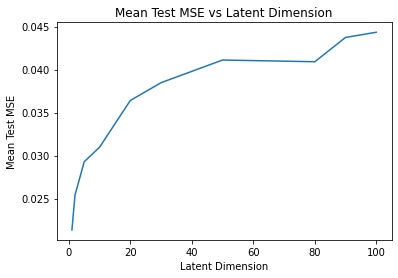

In [194]:
# Plots the mean MSE against the values of Latent Dimension
plt.plot(lat_dims, mse_overall)
plt.title("Mean Test MSE vs Latent Dimension")
plt.xlabel("Latent Dimension")
plt.ylabel("Mean Test MSE")
plt.show()

The plot of average MSE vs. latent dimensionality shows a positive correlation, i.e. MSE increases as the number of latent dimensions increase. The increase in MSE appears to be almost logarithmic, growing rapidly first and then beginning to plateau. This is quite a surprising finding as it seems to imply that the optimal number of latent dimensions is in fact one.

However, it is not ideal to choose the 'best model' through simply looking at the lowest validation loss over only 5 epochs, as it is likely there is still further fitting needed over a larger number of epochs. Therefore, this finding must be taken with a pinch of salt.


**P2.1**

A neural network architecture is now created to learn a permutation-equivariant function.

In [204]:
# Data is loaded into the environment
from google.colab import drive
drive.mount('/content/drive')

X_train1 = pd.read_csv('/content/drive/MyDrive/xtrain-2.csv')
y_train1 = pd.read_csv('/content/drive/MyDrive/ytrain-2.csv')

X_test1 = pd.read_csv('/content/drive/MyDrive/xtest-2.csv')
y_test1 = pd.read_csv('/content/drive/MyDrive/ytest-2.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [205]:
# Redundant columns are removed from the data
y_train = y_train1.iloc[: , 1:]
y_test = y_test1.iloc[: , 1:]
X_train = X_train1.iloc[: , 1:]
X_test = X_test1.iloc[: , 1:]
y_train.shape

(200000, 5)

In [201]:
# Variables are defined
L = 2
w = 5
m = 5
d = 3

# Function that creates permutation-equivariant architecture, taking parameters 
# L and w as input
def perm_equi(L,w): 

  input_layer1 = tf.keras.layers.Input(shape=m*d)
  previous_layer = input_layer1

  # Loop is run L-1 times to create the L-1 inner layers
  for i in range(L-1):
    # Equivariant affine transformation applied to current equiv_layer 
    # Activation is clearly linear for this
    equiv_layer = tf.keras.layers.Dense(m*w, activation='linear')(previous_layer)

    # Layer is reshaped to have output shape (m,w)
    equiv_layer = tf.keras.layers.Reshape((m,w))(equiv_layer)

    # Relu activation is then applied to the layer
    equiv_layer = tf.keras.layers.ReLU()(equiv_layer)

    # Layer is flattened to return to dimension m*w = 15
    equiv_layer = tf.keras.layers.Flatten()(equiv_layer)
    previous_layer = equiv_layer

  # Output has m=5 units 
  output_layer = tf.keras.layers.Dense(m, activation='linear')(previous_layer)
  return tf.keras.Model(inputs = input_layer1, outputs=output_layer)


In [211]:
# Building model
# Optimiser is Adam with learning rate (0.0001)
l_rate = 0.0001
epsilon = 0.001
batch_size = 300
val_split = 0.1
no_epochs = 100

optimiser = tf.optimizers.Adam(learning_rate=l_rate)
model9 = perm_equi(2,5)

model9.compile(optimizer=optimiser, loss='mse', metrics=[tf.keras.metrics.MeanSquaredError()])

**Implementation of this neural network architecture:**

Firstly, the data is processed to move any redundant columns and all variables are defined. 

A function 'perm_equi' is defined, with inputs L and w, to simplify reacreating the model with varying L and w later on. 

Within the function, the input shape is defined as mxd = 15, and an input layer is defined. A for-loop is then run L-1 times to generate each equivariant inner layer. 

Within this loop, the equivariant affine transformation is firstly applied to the layer. The layer is then reshaped so that the output of the dense layer is a tensor with shape (m, w). This is necessary to treat each row as an mxw matrix. The Relu activation function is applied to this layer. The layer is then flattened, and the for loop passes on to the next iteration/layer.

The Adam optimiser is created with learning rate 0.0001 and the model is compiled using MSE as the loss measure.

**P2.2**

The model is trained with (L, w) = (2, 5), (2,10), (2,100), (2,200), (3,5), (3,10), (3,100), and (3,200).

In [212]:
history9 = model9.fit(X_train,                          # training samples
                    y_train,                          # training labels
                    epochs=no_epochs,                 # training steps (epochs)
                    batch_size=batch_size,           # how many data samples per training epoch
                    validation_split=val_split)

test_scores = model9.evaluate(X_test, y_test, batch_size = 128, verbose=2)
print("Test MSE loss:", test_scores[0])

Epoch 1/100
600/600 [==============================] - 4s 4ms/step - loss: 0.5608 - mean_squared_error: 0.5608 - val_loss: 0.3647 - val_mean_squared_error: 0.3647
Epoch 2/100
600/600 [==============================] - 1s 2ms/step - loss: 0.2919 - mean_squared_error: 0.2919 - val_loss: 0.2423 - val_mean_squared_error: 0.2423
Epoch 3/100
600/600 [==============================] - 2s 3ms/step - loss: 0.2201 - mean_squared_error: 0.2201 - val_loss: 0.2030 - val_mean_squared_error: 0.2030
Epoch 4/100
600/600 [==============================] - 3s 5ms/step - loss: 0.1942 - mean_squared_error: 0.1942 - val_loss: 0.1867 - val_mean_squared_error: 0.1867
Epoch 5/100
600/600 [==============================] - 2s 3ms/step - loss: 0.1822 - mean_squared_error: 0.1822 - val_loss: 0.1780 - val_mean_squared_error: 0.1780
Epoch 6/100
600/600 [==============================] - 1s 2ms/step - loss: 0.1751 - mean_squared_error: 0.1751 - val_loss: 0.1726 - val_mean_squared_error: 0.1726
Epoch 7/100
600/600 [=

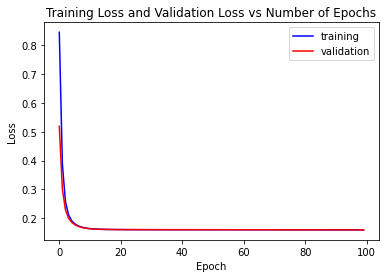

In [31]:
# Plot the training and validation loss versus the number of epochs.
tr_loss = []
val_loss = []

for i in range(100):
  tr_loss.append(history1.history["loss"][i])
  val_loss.append(history1.history["val_loss"][i])
  
plt.plot(range(100), tr_loss, "-b", label="training")
plt.plot(range(100), val_loss, "-r", label="validation")
plt.legend(loc="upper right")
plt.title("Training Loss and Validation Loss vs Number of Epochs")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

In [32]:
m = 5
d = 3
l_rate = 0.0001
epsilon = 0.001
batch_size = 300
val_split = 0.1
no_epochs = 100

optimiser = tf.optimizers.Adam(learning_rate=l_rate)
model2 = perm_equi(2,10)

model2.compile(optimizer=optimiser, loss='mse', metrics=[tf.keras.metrics.MeanSquaredError()])

history2 = model2.fit(X_train,                          # training samples
                    y_train,                          # training labels
                    epochs=no_epochs,                 # training steps (epochs)
                    batch_size=batch_size,           # how many data samples per training epoch
                    validation_split=val_split)

test_scores = model2.evaluate(X_test, y_test, batch_size = 128, verbose=2)
print("Test MSE loss:", test_scores[0])

Epoch 1/100
600/600 [==============================] - 3s 4ms/step - loss: 0.3739 - mean_squared_error: 0.3739 - val_loss: 0.2408 - val_mean_squared_error: 0.2408
Epoch 2/100
600/600 [==============================] - 2s 3ms/step - loss: 0.2126 - mean_squared_error: 0.2126 - val_loss: 0.1952 - val_mean_squared_error: 0.1952
Epoch 3/100
600/600 [==============================] - 2s 3ms/step - loss: 0.1882 - mean_squared_error: 0.1882 - val_loss: 0.1820 - val_mean_squared_error: 0.1820
Epoch 4/100
600/600 [==============================] - 2s 3ms/step - loss: 0.1784 - mean_squared_error: 0.1784 - val_loss: 0.1748 - val_mean_squared_error: 0.1748
Epoch 5/100
600/600 [==============================] - 2s 3ms/step - loss: 0.1726 - mean_squared_error: 0.1726 - val_loss: 0.1703 - val_mean_squared_error: 0.1703
Epoch 6/100
600/600 [==============================] - 2s 2ms/step - loss: 0.1689 - mean_squared_error: 0.1689 - val_loss: 0.1674 - val_mean_squared_error: 0.1674
Epoch 7/100
600/600 [=

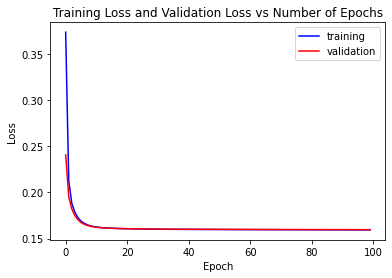

In [33]:
# Plot the training and validation loss versus the number of epochs.
tr_loss = []
val_loss = []

for i in range(100):
  tr_loss.append(history2.history["loss"][i])
  val_loss.append(history2.history["val_loss"][i])
  
plt.plot(range(100), tr_loss, "-b", label="training")
plt.plot(range(100), val_loss, "-r", label="validation")
plt.legend(loc="upper right")
plt.title("Training Loss and Validation Loss vs Number of Epochs")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

In [34]:
m = 5
d = 3
l_rate = 0.0001
epsilon = 0.001
batch_size = 300
val_split = 0.1
no_epochs = 100

optimiser = tf.optimizers.Adam(learning_rate=l_rate)
model3 = perm_equi(2,100)

model3.compile(optimizer=optimiser, loss='mse', metrics=[tf.keras.metrics.MeanSquaredError()])

history3 = model3.fit(X_train,                          # training samples
                    y_train,                          # training labels
                    epochs=no_epochs,                 # training steps (epochs)
                    batch_size=batch_size,           # how many data samples per training epoch
                    validation_split=val_split)

test_scores = model3.evaluate(X_test, y_test, batch_size = 128, verbose=2)
print("Test MSE loss:", test_scores[0])

Epoch 1/100
600/600 [==============================] - 4s 6ms/step - loss: 0.1699 - mean_squared_error: 0.1699 - val_loss: 0.1631 - val_mean_squared_error: 0.1631
Epoch 2/100
600/600 [==============================] - 3s 5ms/step - loss: 0.1620 - mean_squared_error: 0.1620 - val_loss: 0.1617 - val_mean_squared_error: 0.1617
Epoch 3/100
600/600 [==============================] - 4s 6ms/step - loss: 0.1612 - mean_squared_error: 0.1612 - val_loss: 0.1613 - val_mean_squared_error: 0.1613
Epoch 4/100
600/600 [==============================] - 4s 7ms/step - loss: 0.1609 - mean_squared_error: 0.1609 - val_loss: 0.1611 - val_mean_squared_error: 0.1611
Epoch 5/100
600/600 [==============================] - 3s 5ms/step - loss: 0.1607 - mean_squared_error: 0.1607 - val_loss: 0.1611 - val_mean_squared_error: 0.1611
Epoch 6/100
600/600 [==============================] - 3s 5ms/step - loss: 0.1606 - mean_squared_error: 0.1606 - val_loss: 0.1610 - val_mean_squared_error: 0.1610
Epoch 7/100
600/600 [=

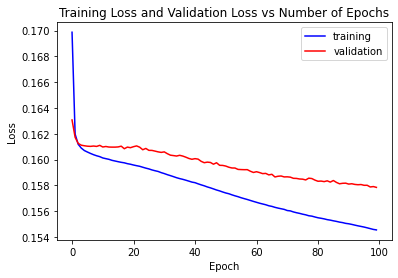

In [35]:
# Plot the training and validation loss versus the number of epochs.
tr_loss = []
val_loss = []

for i in range(100):
  tr_loss.append(history3.history["loss"][i])
  val_loss.append(history3.history["val_loss"][i])
  
plt.plot(range(100), tr_loss, "-b", label="training")
plt.plot(range(100), val_loss, "-r", label="validation")
plt.legend(loc="upper right")
plt.title("Training Loss and Validation Loss vs Number of Epochs")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

In [36]:
m = 5
d = 3
l_rate = 0.0001
epsilon = 0.001
batch_size = 300
val_split = 0.1
no_epochs = 100

optimiser = tf.optimizers.Adam(learning_rate=l_rate)
model4 = perm_equi(3,5)

model4.compile(optimizer=optimiser, loss='mse', metrics=[tf.keras.metrics.MeanSquaredError()])

history4 = model4.fit(X_train,                          # training samples
                    y_train,                          # training labels
                    epochs=no_epochs,                 # training steps (epochs)
                    batch_size=batch_size,           # how many data samples per training epoch
                    validation_split=val_split)

test_scores = model4.evaluate(X_test, y_test, batch_size = 128, verbose=2)
print("Test MSE loss:", test_scores[0])

Epoch 1/100
600/600 [==============================] - 3s 3ms/step - loss: 0.3150 - mean_squared_error: 0.3150 - val_loss: 0.2094 - val_mean_squared_error: 0.2094
Epoch 2/100
600/600 [==============================] - 2s 3ms/step - loss: 0.1918 - mean_squared_error: 0.1918 - val_loss: 0.1813 - val_mean_squared_error: 0.1813
Epoch 3/100
600/600 [==============================] - 2s 3ms/step - loss: 0.1761 - mean_squared_error: 0.1761 - val_loss: 0.1724 - val_mean_squared_error: 0.1724
Epoch 4/100
600/600 [==============================] - 2s 3ms/step - loss: 0.1701 - mean_squared_error: 0.1701 - val_loss: 0.1682 - val_mean_squared_error: 0.1682
Epoch 5/100
600/600 [==============================] - 3s 4ms/step - loss: 0.1669 - mean_squared_error: 0.1669 - val_loss: 0.1657 - val_mean_squared_error: 0.1657
Epoch 6/100
600/600 [==============================] - 2s 3ms/step - loss: 0.1649 - mean_squared_error: 0.1649 - val_loss: 0.1642 - val_mean_squared_error: 0.1642
Epoch 7/100
600/600 [=

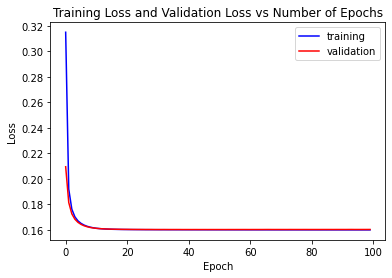

In [37]:
# Plot the training and validation loss versus the number of epochs.
tr_loss = []
val_loss = []

for i in range(100):
  tr_loss.append(history4.history["loss"][i])
  val_loss.append(history4.history["val_loss"][i])
  
plt.plot(range(100), tr_loss, "-b", label="training")
plt.plot(range(100), val_loss, "-r", label="validation")
plt.legend(loc="upper right")
plt.title("Training Loss and Validation Loss vs Number of Epochs")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

In [38]:
m = 5
d = 3
l_rate = 0.0001
epsilon = 0.001
batch_size = 300
val_split = 0.1
no_epochs = 100

optimiser = tf.optimizers.Adam(learning_rate=l_rate)
model5 = perm_equi(3,10)

model5.compile(optimizer=optimiser, loss='mse', metrics=[tf.keras.metrics.MeanSquaredError()])

history5 = model5.fit(X_train,                          # training samples
                    y_train,                          # training labels
                    epochs=no_epochs,                 # training steps (epochs)
                    batch_size=batch_size,           # how many data samples per training epoch
                    validation_split=val_split)

test_scores = model5.evaluate(X_test, y_test, batch_size = 128, verbose=2)
print("Test MSE loss:", test_scores[0])

Epoch 1/100
600/600 [==============================] - 3s 4ms/step - loss: 0.2089 - mean_squared_error: 0.2089 - val_loss: 0.1768 - val_mean_squared_error: 0.1768
Epoch 2/100
600/600 [==============================] - 2s 3ms/step - loss: 0.1720 - mean_squared_error: 0.1720 - val_loss: 0.1687 - val_mean_squared_error: 0.1687
Epoch 3/100
600/600 [==============================] - 3s 5ms/step - loss: 0.1669 - mean_squared_error: 0.1669 - val_loss: 0.1656 - val_mean_squared_error: 0.1656
Epoch 4/100
600/600 [==============================] - 3s 4ms/step - loss: 0.1645 - mean_squared_error: 0.1645 - val_loss: 0.1640 - val_mean_squared_error: 0.1640
Epoch 5/100
600/600 [==============================] - 2s 3ms/step - loss: 0.1632 - mean_squared_error: 0.1632 - val_loss: 0.1629 - val_mean_squared_error: 0.1629
Epoch 6/100
600/600 [==============================] - 2s 3ms/step - loss: 0.1623 - mean_squared_error: 0.1623 - val_loss: 0.1622 - val_mean_squared_error: 0.1622
Epoch 7/100
600/600 [=

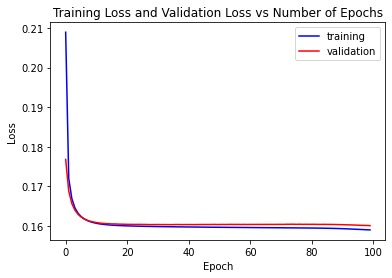

In [39]:
# Plot the training and validation loss versus the number of epochs.
tr_loss = []
val_loss = []

for i in range(100):
  tr_loss.append(history5.history["loss"][i])
  val_loss.append(history5.history["val_loss"][i])
  
plt.plot(range(100), tr_loss, "-b", label="training")
plt.plot(range(100), val_loss, "-r", label="validation")
plt.legend(loc="upper right")
plt.title("Training Loss and Validation Loss vs Number of Epochs")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

In [40]:
m = 5
d = 3
l_rate = 0.0001
epsilon = 0.001
batch_size = 300
val_split = 0.1
no_epochs = 100

optimiser = tf.optimizers.Adam(learning_rate=l_rate)
model6 = perm_equi(3,100)

model6.compile(optimizer=optimiser, loss='mse', metrics=[tf.keras.metrics.MeanSquaredError()])

history6 = model6.fit(X_train,                          # training samples
                    y_train,                          # training labels
                    epochs=no_epochs,                 # training steps (epochs)
                    batch_size=batch_size,           # how many data samples per training epoch
                    validation_split=val_split)

test_scores = model6.evaluate(X_test, y_test, batch_size = 128, verbose=2)
print("Test MSE loss:", test_scores[0])

Epoch 1/100
600/600 [==============================] - 14s 22ms/step - loss: 0.1639 - mean_squared_error: 0.1639 - val_loss: 0.1621 - val_mean_squared_error: 0.1621
Epoch 2/100
600/600 [==============================] - 13s 21ms/step - loss: 0.1612 - mean_squared_error: 0.1612 - val_loss: 0.1615 - val_mean_squared_error: 0.1615
Epoch 3/100
600/600 [==============================] - 12s 20ms/step - loss: 0.1604 - mean_squared_error: 0.1604 - val_loss: 0.1613 - val_mean_squared_error: 0.1613
Epoch 4/100
600/600 [==============================] - 11s 18ms/step - loss: 0.1599 - mean_squared_error: 0.1599 - val_loss: 0.1613 - val_mean_squared_error: 0.1613
Epoch 5/100
600/600 [==============================] - 12s 21ms/step - loss: 0.1596 - mean_squared_error: 0.1596 - val_loss: 0.1613 - val_mean_squared_error: 0.1613
Epoch 6/100
600/600 [==============================] - 12s 21ms/step - loss: 0.1593 - mean_squared_error: 0.1593 - val_loss: 0.1613 - val_mean_squared_error: 0.1613
Epoch 7/10

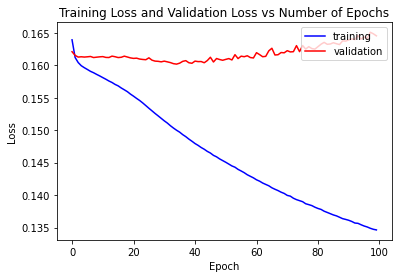

In [41]:
# Plot the training and validation loss versus the number of epochs.
tr_loss = []
val_loss = []

for i in range(100):
  tr_loss.append(history6.history["loss"][i])
  val_loss.append(history6.history["val_loss"][i])
  
plt.plot(range(100), tr_loss, "-b", label="training")
plt.plot(range(100), val_loss, "-r", label="validation")
plt.legend(loc="upper right")
plt.title("Training Loss and Validation Loss vs Number of Epochs")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

In [206]:
m = 5
d = 3
l_rate = 0.0001
epsilon = 0.001
batch_size = 300
val_split = 0.1
no_epochs = 100

optimiser = tf.optimizers.Adam(learning_rate=l_rate)
model7 = perm_equi(3, 200)

model7.compile(optimizer=optimiser, loss='mse', metrics=[tf.keras.metrics.MeanSquaredError()])

history7 = model7.fit(X_train,                          # training samples
                    y_train,                          # training labels
                    epochs=no_epochs,                 # training steps (epochs)
                    batch_size=batch_size,           # how many data samples per training epoch
                    validation_split=val_split)

test_scores = model7.evaluate(X_test, y_test, batch_size = 128, verbose=2)
print("Test MSE loss:", test_scores[0])

Epoch 1/100
600/600 [==============================] - 36s 59ms/step - loss: 0.1627 - mean_squared_error: 0.1627 - val_loss: 0.1615 - val_mean_squared_error: 0.1615
Epoch 2/100
600/600 [==============================] - 37s 62ms/step - loss: 0.1607 - mean_squared_error: 0.1607 - val_loss: 0.1611 - val_mean_squared_error: 0.1611
Epoch 3/100
600/600 [==============================] - 35s 58ms/step - loss: 0.1600 - mean_squared_error: 0.1600 - val_loss: 0.1611 - val_mean_squared_error: 0.1611
Epoch 4/100
600/600 [==============================] - 35s 58ms/step - loss: 0.1595 - mean_squared_error: 0.1595 - val_loss: 0.1617 - val_mean_squared_error: 0.1617
Epoch 5/100
600/600 [==============================] - 36s 61ms/step - loss: 0.1591 - mean_squared_error: 0.1591 - val_loss: 0.1612 - val_mean_squared_error: 0.1612
Epoch 6/100
600/600 [==============================] - 35s 59ms/step - loss: 0.1586 - mean_squared_error: 0.1586 - val_loss: 0.1612 - val_mean_squared_error: 0.1612
Epoch 7/10

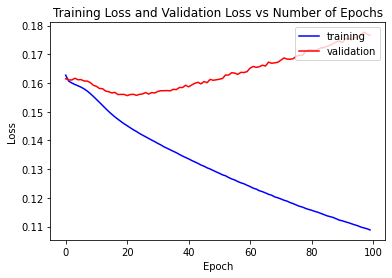

In [207]:
# Plot the training and validation loss versus the number of epochs.
tr_loss = []
val_loss = []

for i in range(100):
  tr_loss.append(history7.history["loss"][i])
  val_loss.append(history7.history["val_loss"][i])
  
plt.plot(range(100), tr_loss, "-b", label="training")
plt.plot(range(100), val_loss, "-r", label="validation")
plt.legend(loc="upper right")
plt.title("Training Loss and Validation Loss vs Number of Epochs")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

In [208]:
m = 5
d = 3
l_rate = 0.0001
epsilon = 0.001
batch_size = 300
val_split = 0.1
no_epochs = 100

optimiser = tf.optimizers.Adam(learning_rate=l_rate)
model8 = perm_equi(2,200)

model8.compile(optimizer=optimiser, loss='mse', metrics=[tf.keras.metrics.MeanSquaredError()])

history8 = model8.fit(X_train,                          # training samples
                    y_train,                          # training labels
                    epochs=no_epochs,                 # training steps (epochs)
                    batch_size=batch_size,           # how many data samples per training epoch
                    validation_split=val_split)

test_scores = model8.evaluate(X_test, y_test, batch_size = 128, verbose=2)
print("Test MSE loss:", test_scores[0])

Epoch 1/100
600/600 [==============================] - 7s 10ms/step - loss: 0.1645 - mean_squared_error: 0.1645 - val_loss: 0.1616 - val_mean_squared_error: 0.1616
Epoch 2/100
600/600 [==============================] - 4s 6ms/step - loss: 0.1610 - mean_squared_error: 0.1610 - val_loss: 0.1611 - val_mean_squared_error: 0.1611
Epoch 3/100
600/600 [==============================] - 4s 6ms/step - loss: 0.1606 - mean_squared_error: 0.1606 - val_loss: 0.1609 - val_mean_squared_error: 0.1609
Epoch 4/100
600/600 [==============================] - 6s 9ms/step - loss: 0.1604 - mean_squared_error: 0.1604 - val_loss: 0.1609 - val_mean_squared_error: 0.1609
Epoch 5/100
600/600 [==============================] - 4s 6ms/step - loss: 0.1602 - mean_squared_error: 0.1602 - val_loss: 0.1611 - val_mean_squared_error: 0.1611
Epoch 6/100
600/600 [==============================] - 4s 6ms/step - loss: 0.1601 - mean_squared_error: 0.1601 - val_loss: 0.1608 - val_mean_squared_error: 0.1608
Epoch 7/100
600/600 [

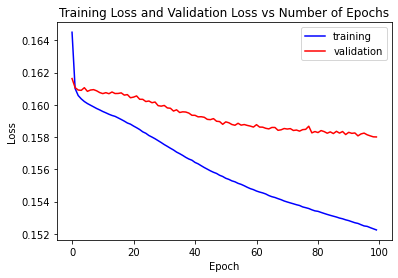

In [209]:
# Plot the training and validation loss versus the number of epochs.
tr_loss = []
val_loss = []

for i in range(100):
  tr_loss.append(history8.history["loss"][i])
  val_loss.append(history8.history["val_loss"][i])
  
plt.plot(range(100), tr_loss, "-b", label="training")
plt.plot(range(100), val_loss, "-r", label="validation")
plt.legend(loc="upper right")
plt.title("Training Loss and Validation Loss vs Number of Epochs")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

In [213]:
test_scores = model9.evaluate(X_test, y_test, batch_size = 128, verbose=2)
print("Test MSE loss (2,5):", test_scores[0])

test_scores = model2.evaluate(X_test, y_test, batch_size = 128, verbose=2)
print("Test MSE loss (2,10):", test_scores[0])

test_scores = model3.evaluate(X_test, y_test, batch_size = 128, verbose=2)
print("Test MSE loss (2,100):", test_scores[0])

test_scores = model8.evaluate(X_test, y_test, batch_size = 128, verbose=2)
print("Test MSE loss (2,200):", test_scores[0])

test_scores = model4.evaluate(X_test, y_test, batch_size = 128, verbose=2)
print("Test MSE loss (3,5):", test_scores[0])

test_scores = model5.evaluate(X_test, y_test, batch_size = 128, verbose=2)
print("Test MSE loss (3,10):", test_scores[0])

test_scores = model6.evaluate(X_test, y_test, batch_size = 128, verbose=2)
print("Test MSE loss (3,100):", test_scores[0])

test_scores = model7.evaluate(X_test, y_test, batch_size = 128, verbose=2)
print("Test MSE loss (3,200):", test_scores[0])

1563/1563 - 2s - loss: 0.1601 - mean_squared_error: 0.1601 - 2s/epoch - 1ms/step
Test MSE loss (2,5): 0.16010744869709015
1563/1563 - 6s - loss: 0.1597 - mean_squared_error: 0.1597 - 6s/epoch - 4ms/step
Test MSE loss (2,10): 0.1597115397453308
1563/1563 - 2s - loss: 0.1577 - mean_squared_error: 0.1577 - 2s/epoch - 1ms/step
Test MSE loss (2,100): 0.1577138602733612
1563/1563 - 3s - loss: 0.1577 - mean_squared_error: 0.1577 - 3s/epoch - 2ms/step
Test MSE loss (2,200): 0.15773995220661163
1563/1563 - 2s - loss: 0.1602 - mean_squared_error: 0.1602 - 2s/epoch - 1ms/step
Test MSE loss (3,5): 0.16019394993782043
1563/1563 - 3s - loss: 0.1600 - mean_squared_error: 0.1600 - 3s/epoch - 2ms/step
Test MSE loss (3,10): 0.16004325449466705
1563/1563 - 6s - loss: 0.1642 - mean_squared_error: 0.1642 - 6s/epoch - 4ms/step
Test MSE loss (3,100): 0.16415314376354218
1563/1563 - 15s - loss: 0.1770 - mean_squared_error: 0.1770 - 15s/epoch - 10ms/step
Test MSE loss (3,200): 0.17702718079090118


**Comparison of loss and test MSE values for training pairs (L,w) = (2,5), (2,10), (2,100), (2,200), (3,5), (3,10), (3,100), and (3,200):**

L represents the number of equivariant layers with the neural network and w represents the width of each equivariant layer. The graph of training and validation loss against epochs is investigated for each (L, w) pair. 

For (L, w) = (2,5), the behaviour of the training and validation loss is quite standard and both converge quite quickly over the first ten epochs. For (L, w) = (2, 10), the graph looks quite similar to (2, 5) but with slightly faster convergence. For (L, w) = (2, 100), it is seen that although the training loss converges towards zero very quickly, validation loss begins to move away from the training loss, suggesting there may be some overfitting with such a large value of w. This distinction between validation and training loss is seen even more clearly for (L, w) = (2, 200), where there is an even larger distance between the training and validation loss - although both are still decreasing throught the epochs, albeit the validation is decreasing slower.

For (L, w) = (3,5), the training and validation loss behave similarly to those for (2, 5), although they converge to zero much more quickly. For (L, w) = (3, 10), the losses converge even more quickly to zero than for (3, 5). The graph for (3, 100) is similar to that of (2, 100) but there is an even larger distinction between the training and validation loss. In fact the validation loss actually begins to increase over the epochs and it is clear there is overfitting of the model. (L, w) = (3, 200) shows an even more extreme example of overfitting, as the training loss decreases very linearly over the epochs but the validation loss does the exact opposite and actually increases linearly over the epochs. 

The test MSE values also give insight into the fit of each of these models. Interestingly, for all values of w, the MSE is lower for L=2, implying that is optimal over L=3 (and that L=3 might lead to overfitting of the model with too many layers and thus too high a complexity).

It is clear from these results that a middle value of L and w must be found to optimally fit the model. The test MSE results suggest that L=2 is optimal, and particularly that the pair (L, w) = (2, 100) might be the optimal pair with which to create the model. The training and validation loss graphs suggest there may be some overfitting even with this model, so it could be safer choice to (L, w) = (2, 10) which still has a low MSE value and did not exhibit any signs of overfitting in the graph.
